# Predicting Cell Behavior from Cell Morphology during Cell-Cell Shear

__Samuel Feinstein, Amil Khan, Lauren Washington, Alice Mo, Liam Dow, Adele Myers, Wanxin Li, Khanh Dao Duc, Nina Miolane__


As a side note, our first initials are one letter away from SALAD.

---

#### Data Source

> Ehsan Sadeghipour, Miguel A Garcia, William James Nelson, Beth L Pruitt (2018) Shear-induced damped oscillations in an epithelium depend on actomyosin contraction and E-cadherin cell adhesion eLife 7:e39640 https://doi.org/10.7554/eLife.39640

>Analysis Adapted from "Elastic Metric for Cell Boundary Analysis" by Adele Myers and Nina Miolane

Confluent MDCK cells on a MEMS device with segmentation by Cellpose 

📸 Images from Liam Dow

---

In [2]:
#plt.figure(figsize=(12, 12))
#plt.imshow(skimage.io.imread("PredictingCellShear/figs/Cropped_Regions@4x.png"))
#plt.axis("off")

# Graphical Abstract
<br> 
<br> 
<!-- <center><img src="PredictingCellShear/figs/Graphical_Abstract_V1@4x.png" width=800px alt="default"/></center> -->
<br> 
<!-- <center>Image from Liam Dow </center> -->

<center><img src="PredictingCellShear/figs/Graphical_Abstract_V1@4x.png" width=900px alt="default"/></center>

In [3]:
#plt.figure(figsize=(12, 12))
#plt.imshow(skimage.io.imread("PredictingCellShear/figs/Graphical_Abstract_V1@4x.png"))
#<center><img src="PredictingCellShear/figs/Graphical_Abstract_V1@4x.png" width=900px alt="default"/></center>
#plt.axis("off")

# Introduction and Motivation

Cell-cell shear, or the action of cells sliding past each other, has roles in development, disease, and wound healing. Throughout development cells are moving past each other in every stage of development. These biomechanical cues have influences on differentiation, cell shape, behavior, the proteome, and the transcriptome. Previous research on shear focused on fluid shear so in this paper they focused on cell-cell shear which has been well characterized. Epithelial cells known as MDCK cells were used on a MEMS device which can be precisely displaced to create consistent cell-cell shear forces. Using new segmentation and machine learning techniques we are reanalyzing the data to use the changes in cell shape to predict cell behavior/migration.
<br> 
<br> 
<!-- <center><img src="figs/Shear_schematic@4x.png" width=800px alt="default"/></center>
<br> 
<center>Schematic of the Shear Device from Liam Dow </center> -->

## Notebook setup

In [4]:
import os
import subprocess
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
work_dir = os.getcwd()
print("Working directory: ", work_dir )

import warnings
warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(work_dir)
sys.path.append(sys_dir)
print("Directories added to path: ", work_dir, sys_dir)


a = gs.array([1., 2.])
print("\nFloat precision:", a.dtype)

Working directory:  C:\Users\sfeinstein\code\cells
Directories added to path:  C:\Users\sfeinstein\code\cells C:\Users\sfeinstein\code

Float precision: float64


## Standard imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## Project-specific imports

In [7]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.mdm import RiemannianMinimumDistanceToMean
from geomstats.learning.pca import TangentPCA

import json
import cells.basic as basic
import cells.ROI_utils as roiu


We import the space of curves shapes equipped with different elastic metrics:
- the square root velocity metric (SRV), which is the canonical elastic metric,
- the generalized elastic metric with parameters a, b.

# Load the dataset of interest

In [ ]:
#we create a dictionary of ROIs
shear_dict = {}


In [ ]:
#we create a dictionary of ROIs
shear_dict = {}
path0 = "E:/Shear_Data/"
path1 = "E:/Shear_Data/Shear/"
path2 = "01_08_2017/"#/01082017_ECR_10x__0minstart_aftershear__30secintervals_1"#/Cropped_Images/"Bottom_plank_0/"
#path3 = "Shear Data/01082017_mf_24hrcontrol/01082017_ECR_10x__0minstart_aftershear__30secintervals_1/Cropped_Images/Bottom_plank_0/ROIs/"
#print(path1+path2+path3+"ROIs")
for f0 in os.listdir(path0):
    for f1 in os.listdir(path0+f0):
        for f2 in os.listdir(path0+f0+'/'+f1):
            #print(path0+f0+'/'+f1+'/'+f2+'/'+f+"/Cropped_Images/Bottom_plank_0/ROIs")
            #print(f)
            #print(f2)
            #print(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Bottom_plank_0/ROIs")
            #print("Shear_Data/"+f0+'/'+f1+'/'+f2+"/Bottom_plank_0/ROIs/")
            roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Bottom_plank_0/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Bottom_plank_0/ROIs/", dictionary = shear_dict)
            roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Bottom_plank_1/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Bottom_plank_1/ROIs/", dictionary = shear_dict)
            roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Bottom_plank_2/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Bottom_plank_2/ROIs/", dictionary = shear_dict)
            roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Top_plank_0/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Top_plank_0/ROIs/", dictionary = shear_dict)
            roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Top_plank_1/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Top_plank_1/ROIs/", dictionary = shear_dict)
            roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Top_plank_2/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Top_plank_2/ROIs/", dictionary = shear_dict)
print(shear_dict['Shear_Data'].keys())

dict_keys(['Blebb_Shear', 'Jasp_Shear', 'No_Shear', 'Shear'])


In [ ]:
# # create json object from dictionary
json = json.dumps(shear_dict)

# open file for writing, "w" 
f = open('C:/Users/sfeinstein/code/cells/cells/data/allshear.json',"w")

# write json object to file
f.write(json)

# close file
f.close()

In [ ]:
print(shear_dict['Shear_Data']['No_Shear']['05_23_2017']['05232017_10x_0minstart_afterpseudoshear_30secintervals_1'].keys())

dict_keys(['Bottom_plank_0', 'Bottom_plank_1', 'Bottom_plank_2', 'Top_plank_0', 'Top_plank_1', 'Top_plank_2'])


In [ ]:
print(shear_dict['Shear Data']['01_11_2017'].keys())
print(shear_dict['Shear Data']['01_11_2017']['01112017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Top_plank_2']['ROIs']['TP-02_01112017_ECR_10x__0minstart_aftershear__30secintervals_1_MMStack_Pos0_TXR_000_Erosion_0px_RoiSet']['001'].keys())

dict_keys(['01112017_ECR_10x__0minstart_aftershear__30secintervals_1', '01112017_ECR_10x__15minstart_beforeshear__30secintervals_1', '01112017_ECR_10x__30minstart_aftershear__5minintervals_1', '01112017_ECR_10x__60minstart_beforeshear__5minintervals_1'])
dict_keys(['type', 'x', 'y', 'n', 'width', 'name', 'position'])


In [ ]:
experimental = shear_dict

In [9]:
#we load the preprocesed shear data via json
f = open('C:/Users/sfeinstein/code/cells/cells/data/allshear.json')
experimental = json.load(f)

We load an experimental cell dataset with `n_cells` and `n_sampling_points` sampled along the boundary of each cell. 

For faster notebook execution, use small value for `n_cells` and `n_sampling_points`.

In [10]:
dataset_name = "ShearData"
#n is number of points on on a cell roi
#001 would be the rois of 1 cell
#might be able to get rid of type, width, name, and position
#watch out for not real cells that are actually tiny dots


n_sampling_points = 100
labels_a_name = "shear"
labels_b_name = "drug"


# Large-Scale Cell Analysis

---

## Load Data

Here we define large-scale to mean >1K cells, simply because this is when our MacBook Pros started taking several minutes for certain computations. So we switched to a more powerful machine (32 Cores, 128GB RAM) to process and analyze the data. 

#### 🚨 ATTENTION 🚨
If you are trying to run our analysis, you need to download the data from the original paper. Once downloaded, run the dictionary building portion, and save the data using the provided `JSON` code. You can reach out to us for the processed data as well. We are currently not hosting it anywhere. 

```
├── 01082017_ECR_10x__0minstart_aftershear__30secintervals_1
│   └── Cropped_Images
│       ├── Bottom_plank_0
│       ├── Bottom_plank_1
│       ├── Bottom_plank_2
│       ├── Top_plank_0
│       ├── Top_plank_1
│       └── Top_plank_2
├── 01082017_ECR_10x__15minstart_beforeshear__30secintervals_1
│   └── Cropped_Images
│       ├── Bottom_plank_0
│       ├── Bottom_plank_1
│       ├── Bottom_plank_2
│       ├── Top_plank_0
│       ├── Top_plank_1
│       └── Top_plank_2
├── 01082017_ECR_10x__30minstart_aftershear__5minintervals_1
│   └── Cropped_Images
│       ├── Bottom_plank_0
│       ├── Bottom_plank_1
│       ├── Bottom_plank_2
│       ├── Top_plank_0
│       ├── Top_plank_1
│       └── Top_plank_2
└── 01082017_ECR_10x__60minstart_beforeshear__5minintervals_1
    └── Cropped_Images
        ├── Bottom_plank_0
        ├── Bottom_plank_1
        ├── Bottom_plank_2
        ├── Top_plank_0
        ├── Top_plank_1
        └── Top_plank_2

32 directories, 0 files
```

In [11]:

def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [ ]:
import skimage
path = "//pruitt-nas1.mcdb.ucsb.edu/Pruitt Lab/Collaborations In Progress Data/Shear_Data_Mine/Shear Data/01082017_mf_24hrcontrol/01082017_ECR_10x__15minstart_beforeshear__30secintervals_1/Cropped_Images/Bottom_plank_0/OG"
#img8   = skimage.io.imread(path + "/BP-00_img_000000001_TXR_000.tif")
#plt.figure(figsize=(20,12))
#plt.imshow(img8)
#img20 = skimage.io.imread(path + "/BP-00_img_000000016_TXR_000.tif")
#plt.imshow(img20)

In [ ]:
#fig = plt.figure(figsize=(16, 6))
#plt.plot(roi['019']['x'], roi['019']['y'], c='red', linewidth=1)

#discard <41 and >100 and interpolate sampling points up to 100 and reduce progressively if necessary
#discard any 25< area >800 microns squared

In [ ]:
def find_key(dictionary, target_key):
    """
    Recursively searches for a key in a nested dictionary.

    Parameters:
        dictionary (dict): The nested dictionary to search.
        target_key (str): The key to find.

    Returns:
        object: The value associated with the target key, or None if the key is not found.

    Example:
        >>> data = {
        ...     'key1': {
        ...         'key2': {
        ...             'key3': 'value3',
        ...             'key4': 'value4'
        ...         }
        ...     }
        ... }
        >>> result = find_key(data, 'key4')
        >>> print(result)
        value4
    """
    if target_key in dictionary:
        return dictionary[target_key]
    
    for value in dictionary.values():
        if isinstance(value, dict):
            result = find_key(value, target_key)
            if result is not None:
                return result
    
    return None

In [ ]:
def find_all_instances(dictionary, target_key1, target_key2, results_list):
    """
    Recursively finds instances of two target keys in a nested dictionary and appends their corresponding values together.

    Parameters:
        dictionary (dict): The nested dictionary to search.
        target_key1 (hashable): The first target key to find.
        target_key2 (hashable): The second target key to find.
        results_list (list): The list where the corresponding values will be appended.

    Returns:
        None

    Example:
        >>> my_dict = {
        ...     "a": 1,
        ...     "b": {"c": 2, "d": 3},
        ...     "e": {"f": 4, "g": {"a": 5, "c": 6}},
        ...     "i": 7
        ... }
        >>> target_key1 = "a"
        >>> target_key2 = "c"
        >>> instances = []
        >>> find_all_instances(my_dict, target_key1, target_key2, instances)
        >>> print(instances)
        [5, 6]
    """
    found_keys = set()
    for key, value in dictionary.items():
        if key == target_key1 or key == target_key2:
            found_keys.add(key)
        elif isinstance(value, dict):
            find_all_instances(value, target_key1, target_key2, results_list)

    if {target_key1, target_key2}.issubset(found_keys):
        results_list.append(np.array([dictionary[target_key1], dictionary[target_key2]]).T)

In [ ]:
find_key(experimental, 'n')
instances = []
find_all_instances(experimental, 'n', 'x', instances)

TypeError: 'str' object is not callable

In [ ]:
#make a figure comparing cells with 10, 20 etc sampling points to see how they look
all_cells = np.sum(np.array(instances)[:,0] <= 10000)
print("Total cells:", np.sum(np.array(instances)[:,0] <= 10000))
print("40 points", np.sum(np.array(instances)[:,0] <= 40), 100*np.sum(np.array(instances)[:,0] <= 40)/all_cells)
print("30 points", np.sum(np.array(instances)[:,0] <= 30), 100*np.sum(np.array(instances)[:,0] <= 30)/all_cells)
print("20 points", np.sum(np.array(instances)[:,0] <= 20), 100*np.sum(np.array(instances)[:,0] <= 20)/all_cells)
print("10 points", np.sum(np.array(instances)[:,0] <= 10), 100*np.sum(np.array(instances)[:,0] <= 10)/all_cells)

print("50 points", np.sum(np.array(instances)[:,0] <= 50), 100*np.sum(np.array(instances)[:,0] <= 50)/all_cells)
100*np.sum(np.array(instances)[:,0] >= 100)/all_cells
#try 90 sampling points?

Total cells: 463930
40 points 71353 15.380122001163969
30 points 18842 4.061388571551743
20 points 6730 1.450649882525381
10 points 5463 1.1775483370336042
50 points 180470 38.90026512620438


1.4310348543961373

In [ ]:
print("90 points", np.sum(np.array(instances)[:,0] >= 90), 100*np.sum(np.array(instances)[:,0] >= 90)/all_cells)

90 points 16574 3.572521716638286


In [16]:
data = experimental
path0 = 'Shear_Data'

for f0 in data[str(path0)]:
    for f1 in data[path0][f0]:
        for f2 in data[path0][f0][f1]:
            

SyntaxError: unexpected EOF while parsing (657120051.py, line 7)

In [47]:
print(data['Shear_Data']['Shear']['01_08_2017']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Bottom_plank_0']['ROIs'].keys())
print(data['Shear_Data'].keys())

dict_keys(['BP-00_img_000000000_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000001_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000002_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000003_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000004_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000005_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000006_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000007_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000008_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000009_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000010_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000011_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000012_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000013_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000014_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000015_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000016_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000017_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000018_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000019_TXR_000_Erosion_0p

In [2]:
data = experimental
path0 = 'Shear_Data'
arrays = []
cells = []
min_points = 35
k_sampling_points = 100
Blebb_Shear = 0
Jasp_Shear = 0
No_Shear = 0
Shear = 0

for f0 in data[path0]:# which shear, noshear, blebb, or jasp
    for f1 in data[path0][f0]:#which experiment
        for f2 in data[path0][f0][f1]:#which time interval
            for f3 in data[path0][f0][f1][f2]:#which plank
                for f4 in data[path0][f0][f1][f2][f3]['ROIs']:#which roiset
                    f5 = (f0 + '_' + f2 + '_' + f4)
                    f5 = roiu.get_array_perplank(data[path0][f0][f1][f2][f3]['ROIs'], f4, min_points = min_points, k_sampling_points = k_sampling_points)
                    arrays.append(f5)
                    if f0 == 'Blebb_Shear': Blebb_Shear += len(f5)
                    if f0 == 'Jasp_Shear': Jasp_Shear += len(f5)
                    if f0 == 'No_Shear': No_Shear += len(f5)
                    if f0 == 'Shear': Shear += len(f5)
            #roiu.get_array_perplank(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Bottom_plank_0/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Bottom_plank_0/ROIs/", dictionary = shear_dict)
            #roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Bottom_plank_1/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Bottom_plank_1/ROIs/", dictionary = shear_dict)
            #roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Bottom_plank_2/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Bottom_plank_2/ROIs/", dictionary = shear_dict)
            #roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Top_plank_0/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Top_plank_0/ROIs/", dictionary = shear_dict)
            #roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Top_plank_1/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Top_plank_1/ROIs/", dictionary = shear_dict)
            #roiu.dictPath(path0+f0+'/'+f1+'/'+f2+"/Cropped_Images/Top_plank_2/ROIs", "Shear_Data/"+f0+'/'+f1+'/'+f2+"/Top_plank_2/ROIs/", dictionary = shear_dict)
    print(Blebb_Shear, Jasp_Shear, No_Shear, Shear)
    print(arrays)
print(arrays)

NameError: name 'data' is not defined

In [ ]:
cells = []
for lst in arrays:
    cells += 

In [ ]:
import cells.ROI_utils as roiu
#from cells.roi_utils as 

data = experimental


plksbpPpost = roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs'], 'BP-00_img_000000019_TXR_000_Erosion_0px_RoiSet')
plksbpMpost = roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs'], 'BP-01_img_000000019_TXR_000_Erosion_0px_RoiSet')
plksbpDpost = roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_2']['ROIs'], 'BP-02_img_000000019_TXR_000_Erosion_0px_RoiSet')

#cell rois 30 seconds before shear
plksbpPpre = roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs'], 'BP-00_img_000000029_TXR_000_Erosion_0px_RoiSet')
plksbpMpre = roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs'], 'BP-01_img_000000029_TXR_000_Erosion_0px_RoiSet')
plksbpDpre = roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_2']['ROIs'], 'BP-02_img_000000029_TXR_000_Erosion_0px_RoiSet')

#np.shape(plksbpPpre)

KeyError: 'ShearData'

In [ ]:
import importlib
importlib.reload(roiu)

<module 'cells.ROI_utils' from 'C:\\Users\\sfeinstein\\code\\cells\\cells\\ROI_utils.py'>

In [ ]:
import importlib
importlib.reload(roiu)
#adding all proximal bottom plank cells
data = experimental
count = 0
cells = []
min_points = 35
k_sampling_points = 100
length_shear_proximal = 0
length_shear_distal = 0
length_noshear_proximal = 0
length_noshear_distal = 0
for lst in data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs']:
    cells += roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs'],str(lst),min_points = min_points, k_sampling_points = k_sampling_points)
#adding proximal top plank cells
for lst in data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Top_plank_0']['ROIs']:
    cells += roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Top_plank_0']['ROIs'],str(lst),min_points = min_points, k_sampling_points = k_sampling_points)
length_shear_proximal = len(cells)
print('shear proximal', length_shear_proximal)
len(cells)
for lst in data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_2']['ROIs']:
    cells += roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_2']['ROIs'],str(lst),min_points = min_points, k_sampling_points = k_sampling_points)
#adding distal top plank cells
for lst in data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Top_plank_2']['ROIs']:
    cells += roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Top_plank_2']['ROIs'],str(lst),min_points = min_points, k_sampling_points = k_sampling_points)
length_shear_distal = len(cells) - length_shear_proximal
print('shear distal', length_shear_distal)
len(cells)

#adding no shear components
#adding all proximal bottom plank cells
for lst in data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs']:
    cells += roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs'],str(lst),min_points = min_points, k_sampling_points = k_sampling_points)
len(cells)
#adding proximal top plank cells
for lst in data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Top_plank_0']['ROIs']:
    cells += roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Top_plank_0']['ROIs'],str(lst),min_points = min_points, k_sampling_points = k_sampling_points)
length_noshear_proximal = len(cells) - length_shear_proximal - length_shear_distal
print('noshear proximal', length_noshear_proximal)
len(cells)
#adding all distal bottom plank cells
for lst in data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_2']['ROIs']:
    cells += roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_2']['ROIs'],str(lst),min_points = min_points, k_sampling_points = k_sampling_points)
len(cells)
#adding distal top plank cells
for lst in data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Top_plank_2']['ROIs']:
    cells += roiu.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Top_plank_2']['ROIs'],str(lst),min_points = min_points, k_sampling_points = k_sampling_points)
length_noshear_distal = len(cells) - length_shear_proximal - length_shear_distal - length_noshear_proximal
print('noshear distal', length_noshear_distal)
len(cells)

shear proximal 9208
shear distal 15298
noshear proximal 7892
noshear distal 7636


40034

In [ ]:
cells = np.array(cells)
np.shape(cells)

(40034, 100, 2)

In [ ]:
cells = np.array(cells)

n_cells = len(cells)
print(n_cells)

a0 = (['shear' for _ in range(length_shear_distal + length_shear_proximal)])
b0 = (['preshear' for _ in range(length_noshear_distal + length_noshear_proximal)])
a1 = (['proximal' for _ in range(length_shear_proximal)]) + (['distal' for _ in range(length_shear_distal)]) 
b1 = (['proximal' for _ in range(length_noshear_proximal)]) + (['distal' for _ in range(length_noshear_distal)])

labels_a = np.append(a0,b0)
labels_b = np.append(a1,b1)
# print((labels_a))
print((np.unique(labels_a)))
print((np.unique(labels_b)))

print(n_cells)

#for initial testing
#cells = np.concatenate((bottom_proximal_pre,bottom_proximal_post), axis = 0)
print(len(cells))
cell_shapes = cells

40034
['preshear' 'shear']
['distal' 'proximal']
40034
40034


In [ ]:
n_cells = len(bottom_proximal_pre) + len(bottom_proximal_post)
print(n_cells)
a0 = (['preshear' for _ in range(len(bottom_proximal_pre))])
b0 = (['shear' for _ in range(len(bottom_proximal_post))])
a1 = (['45' for _ in range(lengthspre[0])])
a2 = (['45.5' for _ in range(lengthspre[1])])
a3 = (['46' for _ in range(lengthspre[2])])
a4 = (['46.5' for _ in range(lengthspre[3])])
a5 = (['47' for _ in range(lengthspre[4])])
a6 = (['47.5' for _ in range(lengthspre[5])])
a7 = (['48' for _ in range(lengthspre[6])])
a8 = (['48.5' for _ in range(lengthspre[7])])
a9 = (['49' for _ in range(lengthspre[8])])
a10 = (['49.5' for _ in range(lengthspre[9])])
a11 = (['50' for _ in range(lengthspre[10])])
a12 = (['50.5' for _ in range(lengthspre[11])])
a13 = (['51' for _ in range(lengthspre[12])])
a14 = (['51.5' for _ in range(lengthspre[13])])
a15 = (['52' for _ in range(lengthspre[14])])
a16 = (['52.5' for _ in range(lengthspre[15])])
a17 = (['53' for _ in range(lengthspre[16])])
a18 = (['53.5' for _ in range(lengthspre[17])])
a19 = (['54' for _ in range(lengthspre[18])])
a20 = (['54.5' for _ in range(lengthspre[19])])
a21 = (['55' for _ in range(lengthspre[20])])
a22 = (['55.5' for _ in range(lengthspre[21])])
a23 = (['56' for _ in range(lengthspre[22])])
a24 = (['56.5' for _ in range(lengthspre[23])])
a25 = (['57' for _ in range(lengthspre[24])])
a26 = (['57.5' for _ in range(lengthspre[25])])
a27 = (['58' for _ in range(lengthspre[26])])
a28 = (['58.5' for _ in range(lengthspre[27])])
a29 = (['59' for _ in range(lengthspre[28])])
a30 = (['59.5' for _ in range(lengthspre[29])])
a31 = (['60' for _ in range(lengthspre[30])])
a1 += a2 + a3 + a4 + a5 + a6 + a7 + a8 + a9 + a10 + a11 + a12 + a13 + a14 + a15 + a16 + a17 + a18 + a19 + a20 + a21 + a22 + a23 + a24 + a25 + a26 + a27 + a28 + a29 + a30 + a31

b1 = ([ '60' for _ in range(length_shear_proximal[0] )])
b2 = ([ '60.5' for _ in range(length_shear_proximal[1] )])
b3 = ([ '61' for _ in range(length_shear_proximal[2] )])
b4 = ([ '61.5' for _ in range(length_shear_proximal[3] )])
b5 = ([ '62' for _ in range(length_shear_proximal[4] )])
b6 = ([ '62.5' for _ in range(length_shear_proximal[5] )])
b7 = ([ '63' for _ in range(length_shear_proximal[6] )])
b8 = ([ '63.5' for _ in range(length_shear_proximal[7] )])
b9 = ([ '64' for _ in range(length_shear_proximal[8] )])
b10 = ([ '64.5' for _ in range(length_shear_proximal[9] )])
b11 = ([ '65' for _ in range(length_shear_proximal[10] )])
b12 = ([ '65.5' for _ in range(length_shear_proximal[11] )])
b13 = ([ '66' for _ in range(length_shear_proximal[12] )])
b14 = ([ '66.5' for _ in range(length_shear_proximal[13] )])
b15 = ([ '67' for _ in range(length_shear_proximal[14] )])
b16 = ([ '67.5' for _ in range(length_shear_proximal[15] )])
b17 = ([ '68' for _ in range(length_shear_proximal[16] )])
b18 = ([ '68.5' for _ in range(length_shear_proximal[17] )])
b19 = ([ '69' for _ in range(length_shear_proximal[18] )])
b20 = ([ '69.5' for _ in range(length_shear_proximal[19] )])
b21 = ([ '70' for _ in range(length_shear_proximal[20] )])
b22 = ([ '70.5' for _ in range(length_shear_proximal[21] )])
b23 = ([ '71' for _ in range(length_shear_proximal[22] )])
b24 = ([ '71.5' for _ in range(length_shear_proximal[23] )])
b25 = ([ '72' for _ in range(length_shear_proximal[24] )])
b26 = ([ '72.5' for _ in range(length_shear_proximal[25] )])
b27 = ([ '73' for _ in range(length_shear_proximal[26] )])
b28 = ([ '73.5' for _ in range(length_shear_proximal[27] )])
b29 = ([ '74' for _ in range(length_shear_proximal[28] )])
b30 = ([ '74.5' for _ in range(length_shear_proximal[29] )])
b31 = ([ '75' for _ in range(length_shear_proximal[30] )])
b32 = ([ '75.5' for _ in range(length_shear_proximal[31] )])
b33 = ([ '76' for _ in range(length_shear_proximal[32] )])
b34 = ([ '76.5' for _ in range(length_shear_proximal[33] )])
b35 = ([ '77' for _ in range(length_shear_proximal[34] )])
b36 = ([ '77.5' for _ in range(length_shear_proximal[35] )])
b37 = ([ '78' for _ in range(length_shear_proximal[36] )])
b38 = ([ '78.5' for _ in range(length_shear_proximal[37] )])
b39 = ([ '79' for _ in range(length_shear_proximal[38] )])
b40 = ([ '79.5' for _ in range(length_shear_proximal[39] )])
b41 = ([ '80' for _ in range(length_shear_proximal[40] )])
b42 = ([ '80.5' for _ in range(length_shear_proximal[41] )])
b43 = ([ '81' for _ in range(length_shear_proximal[42] )])
b44 = ([ '81.5' for _ in range(length_shear_proximal[43] )])
b45 = ([ '82' for _ in range(length_shear_proximal[44] )])
b46 = ([ '82.5' for _ in range(length_shear_proximal[45] )])
b47 = ([ '83' for _ in range(length_shear_proximal[46] )])
b48 = ([ '83.5' for _ in range(length_shear_proximal[47] )])
b49 = ([ '84' for _ in range(length_shear_proximal[48] )])
b50 = ([ '84.5' for _ in range(length_shear_proximal[49] )])
b51 = ([ '85' for _ in range(length_shear_proximal[50] )])
b52 = ([ '85.5' for _ in range(length_shear_proximal[51] )])
b53 = ([ '86' for _ in range(length_shear_proximal[52] )])
b54 = ([ '86.5' for _ in range(length_shear_proximal[53] )])
b55 = ([ '87' for _ in range(length_shear_proximal[54] )])
b56 = ([ '87.5' for _ in range(length_shear_proximal[55] )])
b57 = ([ '88' for _ in range(length_shear_proximal[56] )])
b58 = ([ '88.5' for _ in range(length_shear_proximal[57] )])
b59 = ([ '89' for _ in range(length_shear_proximal[58] )])
b60 = ([ '89.5' for _ in range(length_shear_proximal[59] )])
b61 = ([ '90' for _ in range(length_shear_proximal[60] )])
b1 += b2 + b3 + b4 + b5 + b6 + b7 + b8 + b9 + b10 + b11 + b12 + b13 + b14 + b15 + b16 + b17 + b18 + b19 + b20 + b21 + b22 + b23 + b24 + b25 + b26 + b27 + b28 + b29 + b30 + b31 + b32 + b33 + b34 + b35 + b36 + b37 + b38 + b39 + b40 + b41 + b42 + b43 + b44 + b45 + b46 + b47 + b48 + b49 + b50 + b51 + b52 + b53 + b54 + b55 + b56 + b57 + b58 + b59 + b60 + b61



labels_a = np.append(a0,b0)
labels_b = np.append(a1,b1)
# print((labels_a))
print((np.unique(labels_a)))
print((np.unique(labels_b)))

print(n_cells)

#for initial testing
cells = np.concatenate((bottom_proximal_pre,bottom_proximal_post), axis = 0)
print(len(cells))
cell_shapes = cells

10595
['preshear' 'shear']
['45' '45.5' '46' '46.5' '47' '47.5' '48' '48.5' '49' '49.5' '50' '50.5'
 '51' '51.5' '52' '52.5' '53' '53.5' '54' '54.5' '55' '55.5' '56' '56.5'
 '57' '57.5' '58' '58.5' '59' '59.5' '60' '60.5' '61' '61.5' '62' '62.5'
 '63' '63.5' '64' '64.5' '65' '65.5' '66' '66.5' '67' '67.5' '68' '68.5'
 '69' '69.5' '70' '70.5' '71' '71.5' '72' '72.5' '73' '73.5' '74' '74.5'
 '75' '75.5' '76' '76.5' '77' '77.5' '78' '78.5' '79' '79.5' '80' '80.5'
 '81' '81.5' '82' '82.5' '83' '83.5' '84' '84.5' '85' '85.5' '86' '86.5'
 '87' '87.5' '88' '88.5' '89' '89.5' '90']
10595
10595


In [ ]:
print(length_shear_proximal)

[108, 119, 112, 117, 121, 111, 135, 131, 132, 114, 120, 108, 53, 80, 113, 103, 86, 107, 121, 100, 107, 81, 104, 89, 109, 92, 97, 62, 106, 85, 96, 72, 88, 100, 86, 104, 87, 47, 87, 83, 51, 90, 66, 88, 55, 82, 58, 83, 49, 91, 52, 87, 64, 101, 83, 40, 29, 43, 84, 96, 58]


In [ ]:
print(type(bottom_proximal_pre))
print(len(cells))

<class 'numpy.ndarray'>
8642


---
# Geomstats for Cell Shape Analysis

We apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the $\ell_2$ distance) two sets of landmarks. These operations will be performed by leveraging the geometry of the so-called Kendall preshape spaces and specifically its method `PRESHAPE_SPACE.projection`.

We can compute geodesics between discrete curves with respect to the elastic metric. In our data, these geodesics represent trajectories between cell boundaries that minimize an elastic energy, and the length of the geodesic defines a distance between curves. We illustrate such a geodesic between two cells.

### Procrustes Analysis

$\color{#EF5645}{\text{Definition}}$: _Procrustes Analysis_ is a general method to perform machine learning on shapes of objects defined by sets of landmarks $X_0, ..., X_n$.

1. Superimpose objects $X_0, ..., X_n$: translate, rotate, possibly scale.

- This sends objects in a _Kendall shape space_ with `KendallShapeMetric`.

<center><img src="PredictingCellShear/figs/02_procrustes.png" width=900px alt="default"/></center>

2. Perform machine learning on superimposed objects (shapes).


$\rightarrow$ $\color{#EF5645}{\text{Remark}}$: Quotient SRV Analysis is an equivalent of Procrustes analysis for curves.

Adapted from Nina Miolane ECE594N Lecture 2b Curves

### SRV Quotient Analysis

$\color{#EF5645}{\text{Definition}}$: _SRV Quotient Analysis_ is a general method to perform machine learning on shapes of objects defined by discrete curves $X_0, ..., X_n$.

1. Superimpose objects $X_0, ..., X_n$: translate, rotate, possibly scale, and reparameterize.

- This sends objects in a _SRV quotient space_ with `SRVQuotientMetric`.

2. Perform machine learning on superimposed objects (shapes).

Adapted from Nina Miolane ECE594N Lecture 2b Curves

In [ ]:

quotient = ["rotation", "scaling"] #, "rotation"]
do_not_quotient = False

SAVEFIG = True
if SAVEFIG:
    figs_dir = os.path.join(work_dir, f"cells/saved_figs/{dataset_name}")
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)
    print(f"Will save figs to {figs_dir}")
    from datetime import datetime

    now = datetime.now().strftime("%Y%m%d_%H_%M_%S")
    print(now)

Will save figs to C:\Users\sfeinstein\code\cells\cells/saved_figs/ShearData
20230613_13_35_47


In [ ]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=50)
PRESHAPE_METRIC = PRESHAPE_SPACE.embedding_space.metric


In [ ]:

#aligned = []
#for lst in cells:
#    prshape = PRESHAPE_SPACE.projection(lst)
#    aligned.append(roiu.exhaustive_align(prshape, cells))


In [ ]:
from geomstats.geometry.discrete_curves import SRVQuotientMetric
r2 = Euclidean(dim=2); curves_r2 = DiscreteCurves(ambient_manifold=r2)
k_sampling_points = 100
srv_quotient_metric = SRVQuotientMetric(
    ambient_manifold=r2, 
    k_sampling_points=k_sampling_points)

In [ ]:
prshape = PRESHAPE_SPACE.projection(cells)
#aligned.append(roiu.exhaustive_align(prshape), img[0])


In [ ]:
"""
BASE_CURVE=lst_bpimg1[0]
unaligned_cell = lst_bpimg1[1]
aligned_cell = aligned[7]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")
"""

'\nBASE_CURVE=lst_bpimg1[0]\nunaligned_cell = lst_bpimg1[1]\naligned_cell = aligned[7]\n\nfig = plt.figure(figsize=(15, 5))\n\nfig.add_subplot(131)\nplt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])\nplt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")\nplt.axis("equal")\nplt.title("Reference curve")\n\nfig.add_subplot(132)\nplt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])\nplt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")\nplt.axis("equal")\nplt.title("Unaligned curve")\n\nfig.add_subplot(133)\nplt.plot(aligned_cell[:, 0], aligned_cell[:, 1])\nplt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")\nplt.axis("equal")\nplt.title("Aligned curve")\n'

In [ ]:
#gs.array(aligned).shape

In [ ]:
#data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs'].keys()

data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs'].keys()

dict_keys(['BP-00_img_000000000_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000001_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000002_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000003_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000004_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000005_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000006_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000007_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000008_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000009_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000010_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000011_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000012_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000013_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000014_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000015_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000016_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000017_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000018_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000019_TXR_000_Erosion_0p

The variable `quotient` is used to define what is called a `cell_shape`.
- `cells`: has only removed the effect of the translation
- `cell_shapes`: additionally removes what is written in `quotient`: the effect of the scaling, and of the rotation.

Note: in the previous analysis, we were using the linear euclidean metric on cells (without translation), and the srv metric on cell shapes (without translation, scaling and rotation).

This notebook compares the linear versus the srv metric on data on which the same preprocessing has been performed, which is given by the variable `quotient`.

In [ ]:
print(quotient)
print(do_not_quotient)

['rotation', 'scaling']
False


In [ ]:
labels_a_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_a))}
labels_b_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_b))}

print(f"Dictionary associated to label \"{labels_a_name}\":")
print(labels_a_dict)
print(f"Dictionary associated to label \"{labels_b_name}\":")
print(labels_b_dict)


Dictionary associated to label "shear":
{'preshear': 0, 'shear': 1}
Dictionary associated to label "location":
{'distal': 0, 'proximal': 1}


In [ ]:
if do_not_quotient:
    cell_shapes = cells

# Visualize sample cells

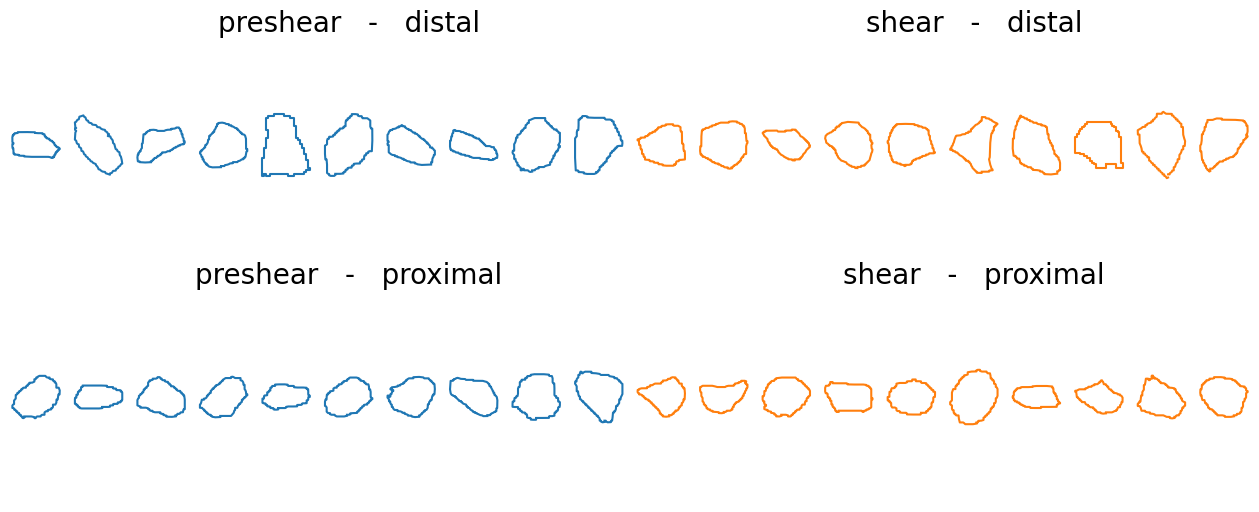

In [ ]:
n_cells_to_plot = 10

fig = plt.figure(figsize=(16, 6))
count = 1
for label_b in np.unique(labels_b):
    for i_lab_a, label_a in enumerate(np.unique(labels_a)):
        cell_data = [cell for cell, lab_a, lab_b in zip(cell_shapes, labels_a, labels_b) if lab_a == label_a and lab_b == label_b]
        #print(len(cell_data))
        #print(len(np.unique(labels_a)))
        for i_to_plot in range(n_cells_to_plot):
            #print(len(cell_data))
            cell = gs.random.choice(a=cell_data)
            fig.add_subplot(len(np.unique(labels_b)), len(np.unique(labels_a)) * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color=f"C{i_lab_a}" )
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{label_a}   -   {label_b}", fontsize=20)
#print(len(np.unique(labels_a)))
#print(len(np.unique(labels_b)))


In [ ]:
print(len(np.unique(labels_a)))
print(len(np.unique(labels_b)))

2
2


7636
15298
7892
9208


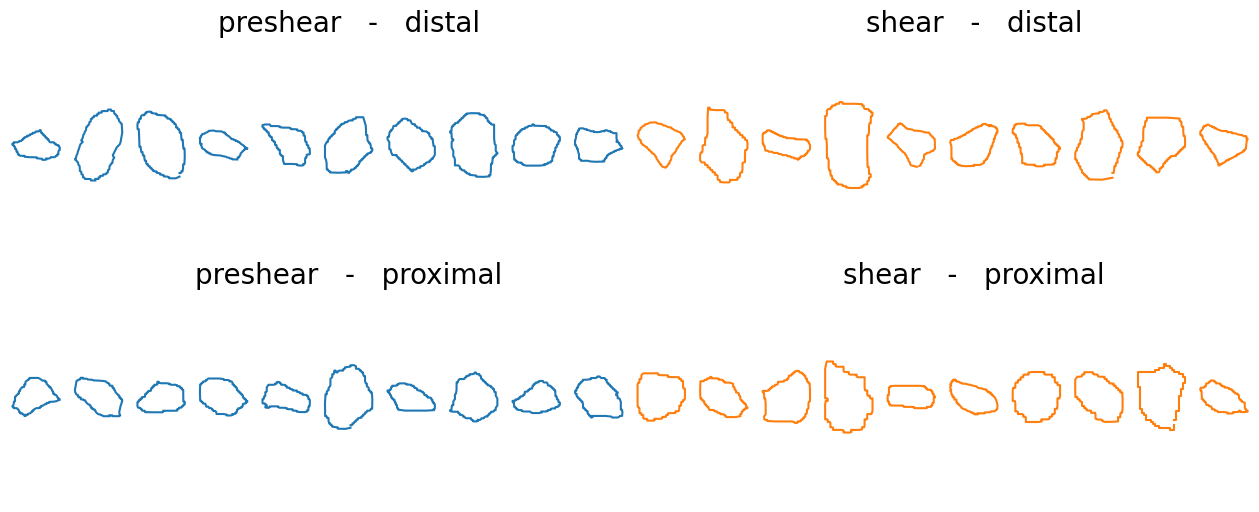

In [ ]:
fig = plt.figure(figsize=(16, 6))

count = 1
for label_b in np.unique(labels_b):
    for i_lab_a, label_a in enumerate(np.unique(labels_a)):
        cell_data = [cell for cell, lab_a, lab_b in zip(cell_shapes, labels_a, labels_b) if lab_a == label_a and lab_b == label_b]
        print(len(cell_data))
        # break
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(a=cell_data)
            fig.add_subplot(len(np.unique(labels_b)), len(np.unique(labels_a)) * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color=f"C{i_lab_a}" )
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{label_a}   -   {label_b}", fontsize=20)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_sample_cells.svg"))


We observe that generally:
- treated cells are more irregular than control cells,
- dunn cells are more irregular than dlm8 cells.

## Define Shape Spaces

In [ ]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
AS = [1, 2, 0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
BS = [0.5, 1, 0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

# Sample Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [ ]:
means = {}

means["Linear"] = gs.mean(cells, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cells).estimate_

In [ ]:
for a, b in zip(AS, BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            method="default").fit(cells).estimate_

We plote the cell shapes corresponding to the means with different metrics.

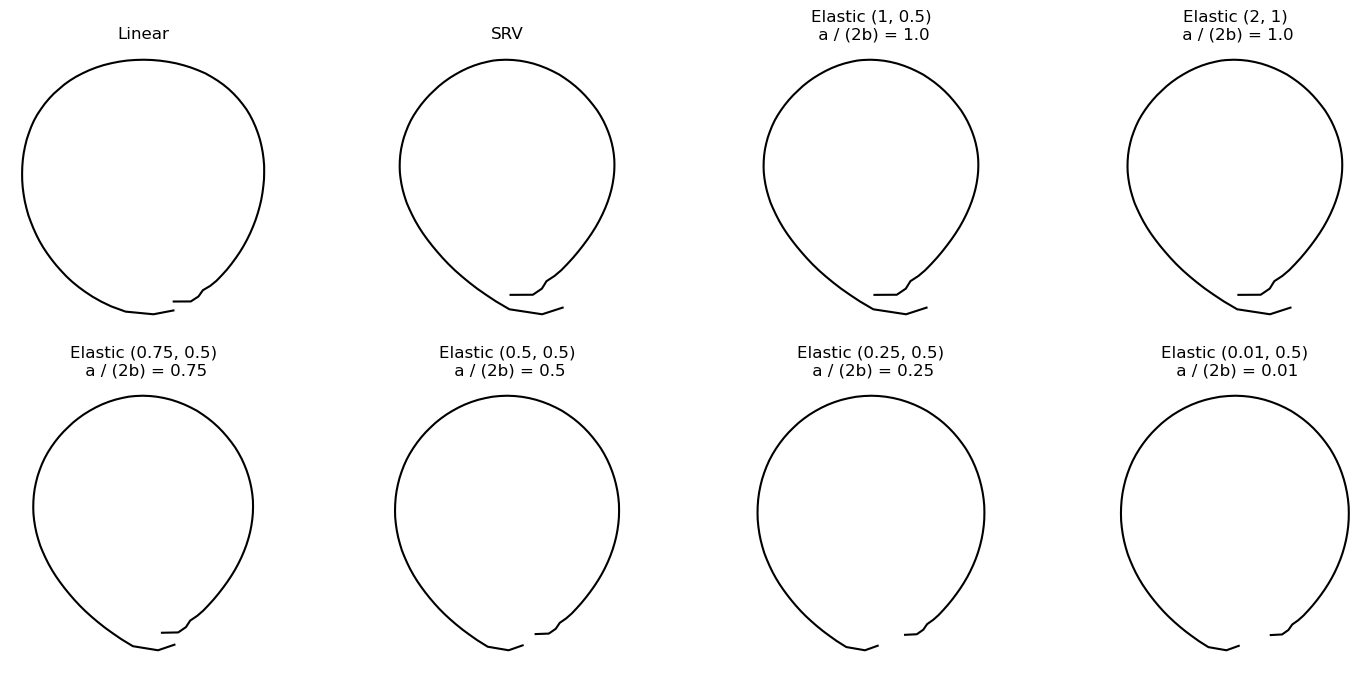

In [ ]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
    
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_open_means.svg"))

We attempt to plot the closed versions of these means:

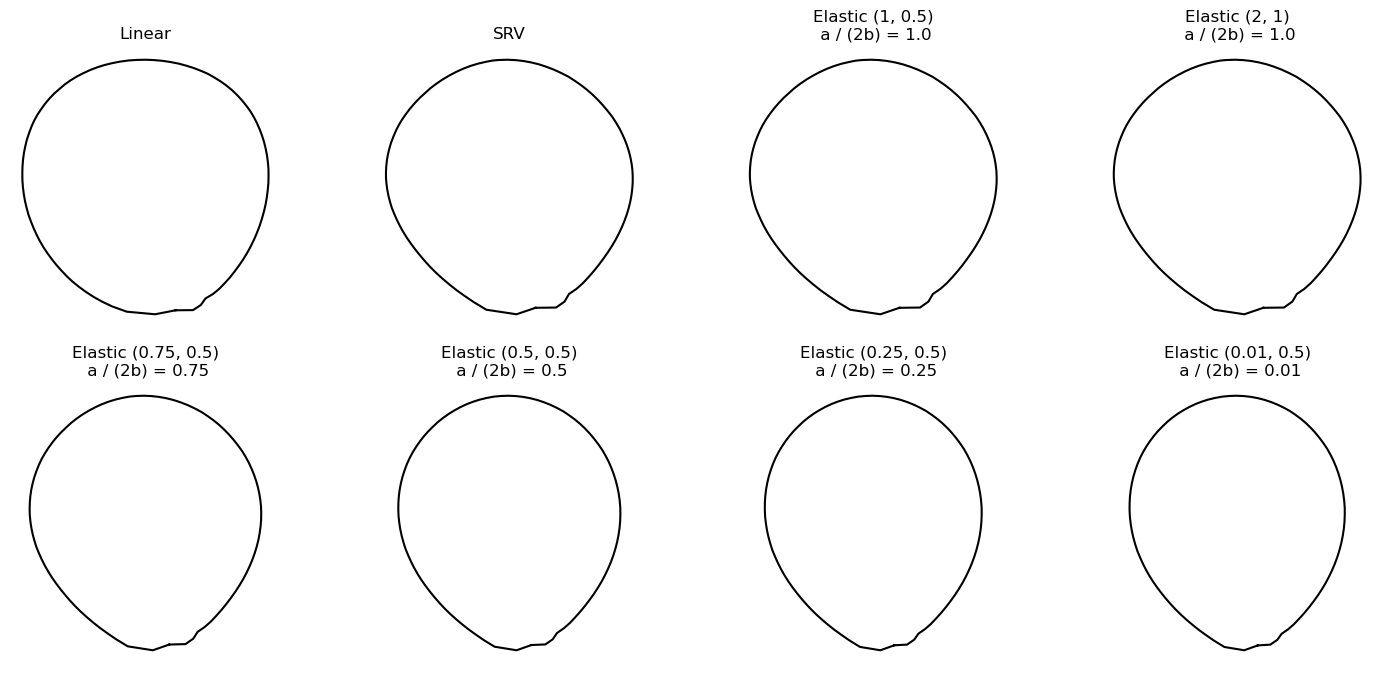

In [ ]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_closed_means.svg"))

**Remark:** Unfortunately, there are some numerical issues with the projection in the space of closed curves, as shown by the V-shaped results above.

Since ratios of 1 give the same results as for the SRV metric, we only select AS, BS with a ratio that is not 1 for the elastic metrics.

We also continue the analysis with the space of open curves, as opposed to the space of closed curves, for the numerical issues observed above.

In [ ]:
NEW_AS = [0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
NEW_BS = [0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]

# Distances to the mean(s)

We compute the distances between:
- every cell **shape** in the dataset `cell_shapes`
  - Note: in the version of the notebook from Aug. 4th, we used every cell in the dataset `cells`, i.e. without quotient of scaling and rotation.
- and the mean cell shape, according to the different metrics: Euclidean (Linear), SRV and Elastic Metrics.

In [ ]:
# We multiply the distances by a 100, for visualization purposes. It amounts to a change of units.
n_sampling_points = 100

dists = {}

dists["Linear"] = [100 * gs.linalg.norm(means["Linear"] - cell) / n_sampling_points for cell in cells]

dists["SRV"] = [
    100 * SRV_METRIC.dist(means["SRV"], cell) / n_sampling_points for cell in cells
]

for a, b in zip(NEW_AS, NEW_BS):
    dists[a, b] =  [
    100 * ELASTIC_METRIC[a, b].dist(means[a, b], cell) / n_sampling_points for cell in cells
]

In [ ]:
print(len(labels_a_name))
print(len(labels_b_name))
print(len(dists))
print(len(dists["Linear"]))
print(len(dists["SRV"]))


5
8
6
40034
40034


In [ ]:
dists_summary = pd.DataFrame(
    data={
        labels_a_name: labels_a,
        labels_b_name: labels_b,
        "Linear": dists["Linear"],
        "SRV": dists["SRV"],
    }
)

for a, b in zip(NEW_AS, NEW_BS):
    dists_summary[f"Elastic({a}, {b})"] = dists[a, b]

In [ ]:
dists_summary.head()

shear  location       Linear       SRV  Elastic(0.75, 0.5)   
0  shear  proximal  1342.648682  7.529212            6.453674  \
1  shear  proximal  4140.452637  6.371561            5.485465   
2  shear  proximal   658.096069  6.296912            5.276754   
3  shear  proximal  6062.332031  6.335895            5.274429   
4  shear  proximal  1568.043823  6.717047            5.673367   

   Elastic(0.5, 0.5)  Elastic(0.25, 0.5)  Elastic(0.01, 0.5)  
0           5.264397            4.220645            3.772818  
1           4.530110            3.715329            3.374729  
2           4.238960            3.379824            3.022968  
3           4.125103            3.100430            2.642484  
4           4.502517            3.439905            2.963932

In [ ]:
xx = {}

for metric_name in ["Linear", "SRV"]:
    min_dists = gs.array(min(dists_summary[metric_name]))
    max_dists = gs.array(max(dists_summary[metric_name]))
    xx[metric_name] = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), 100)
    print(min_dists, max_dists)

50.76189041137695 6299.91162109375
5.401829162733955 13.880885980228078


In [ ]:
def hist_dists_to_means(labels, labels_name, label_color_incr):
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))
    print(labels)
    print(labels_name)

    for i, dist_name in enumerate(["Linear", "SRV"]):
        for i_lab, label in enumerate(np.unique(labels)):
            aux = dists_summary
            display(aux)
            ds = dists_summary[dist_name][dists_summary[labels_name] == label]
            axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
            )
            kde = stats.gaussian_kde(ds)

            axs[i].plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n {dist_name} mean\n colored by {labels_name}\n ")


    fig, axs = plt.subplots(1, len(NEW_AS), figsize=(18, 2), sharey=True)

    for i, (a, b) in enumerate(zip(NEW_AS, NEW_BS)):
        for i_lab, label in enumerate(np.unique(labels)):
            ds = dists_summary[f"Elastic({a}, {b})"][dists_summary[labels_name] == label]
            axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
            )
            kde = stats.gaussian_kde(ds)
            axs[i].plot(xx[metric_name], kde(xx[metric_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n Elastic({a}, {b}) mean\n colored by {labels_name}\n")

['shear' 'shear' 'shear' ... 'preshear' 'preshear' 'preshear']
shear


shear  location       Linear       SRV  Elastic(0.75, 0.5)   
0         shear  proximal  1342.648682  7.529212            6.453674  \
1         shear  proximal  4140.452637  6.371561            5.485465   
2         shear  proximal   658.096069  6.296912            5.276754   
3         shear  proximal  6062.332031  6.335895            5.274429   
4         shear  proximal  1568.043823  6.717047            5.673367   
...         ...       ...          ...       ...                 ...   
40029  preshear    distal   556.606262  7.039009            6.008134   
40030  preshear    distal  3837.423828  8.537434            7.398668   
40031  preshear    distal  3481.139160  7.931010            6.742973   
40032  preshear    distal  1377.930054  7.746829            6.543987   
40033  preshear    distal  6082.951660  5.977164            4.964023   

       Elastic(0.5, 0.5)  Elastic(0.25, 0.5)  Elastic(0.01, 0.5)  
0               5.264397            4.220645            3.772818  
1               4.530110            3.715329            3.374729  
2               4.238960            3.379824            3.022968  
3               4.125103            3.100430            2.642484  
4               4.502517            3.439905            2.963932  
...                  ...                 ...                 ...  
40029           4.893580            3.926767            3.514289  
40030           6.107540            4.958422            4.463685  
40031           5.485555            4.414653            3.963486  
40032           5.208507            4.005444            3.470217  
40033           3.882159            2.928235            2.505511  

[40034 rows x 8 columns]

shear  location       Linear       SRV  Elastic(0.75, 0.5)   
0         shear  proximal  1342.648682  7.529212            6.453674  \
1         shear  proximal  4140.452637  6.371561            5.485465   
2         shear  proximal   658.096069  6.296912            5.276754   
3         shear  proximal  6062.332031  6.335895            5.274429   
4         shear  proximal  1568.043823  6.717047            5.673367   
...         ...       ...          ...       ...                 ...   
40029  preshear    distal   556.606262  7.039009            6.008134   
40030  preshear    distal  3837.423828  8.537434            7.398668   
40031  preshear    distal  3481.139160  7.931010            6.742973   
40032  preshear    distal  1377.930054  7.746829            6.543987   
40033  preshear    distal  6082.951660  5.977164            4.964023   

       Elastic(0.5, 0.5)  Elastic(0.25, 0.5)  Elastic(0.01, 0.5)  
0               5.264397            4.220645            3.772818  
1               4.530110            3.715329            3.374729  
2               4.238960            3.379824            3.022968  
3               4.125103            3.100430            2.642484  
4               4.502517            3.439905            2.963932  
...                  ...                 ...                 ...  
40029           4.893580            3.926767            3.514289  
40030           6.107540            4.958422            4.463685  
40031           5.485555            4.414653            3.963486  
40032           5.208507            4.005444            3.470217  
40033           3.882159            2.928235            2.505511  

[40034 rows x 8 columns]

shear  location       Linear       SRV  Elastic(0.75, 0.5)   
0         shear  proximal  1342.648682  7.529212            6.453674  \
1         shear  proximal  4140.452637  6.371561            5.485465   
2         shear  proximal   658.096069  6.296912            5.276754   
3         shear  proximal  6062.332031  6.335895            5.274429   
4         shear  proximal  1568.043823  6.717047            5.673367   
...         ...       ...          ...       ...                 ...   
40029  preshear    distal   556.606262  7.039009            6.008134   
40030  preshear    distal  3837.423828  8.537434            7.398668   
40031  preshear    distal  3481.139160  7.931010            6.742973   
40032  preshear    distal  1377.930054  7.746829            6.543987   
40033  preshear    distal  6082.951660  5.977164            4.964023   

       Elastic(0.5, 0.5)  Elastic(0.25, 0.5)  Elastic(0.01, 0.5)  
0               5.264397            4.220645            3.772818  
1               4.530110            3.715329            3.374729  
2               4.238960            3.379824            3.022968  
3               4.125103            3.100430            2.642484  
4               4.502517            3.439905            2.963932  
...                  ...                 ...                 ...  
40029           4.893580            3.926767            3.514289  
40030           6.107540            4.958422            4.463685  
40031           5.485555            4.414653            3.963486  
40032           5.208507            4.005444            3.470217  
40033           3.882159            2.928235            2.505511  

[40034 rows x 8 columns]

shear  location       Linear       SRV  Elastic(0.75, 0.5)   
0         shear  proximal  1342.648682  7.529212            6.453674  \
1         shear  proximal  4140.452637  6.371561            5.485465   
2         shear  proximal   658.096069  6.296912            5.276754   
3         shear  proximal  6062.332031  6.335895            5.274429   
4         shear  proximal  1568.043823  6.717047            5.673367   
...         ...       ...          ...       ...                 ...   
40029  preshear    distal   556.606262  7.039009            6.008134   
40030  preshear    distal  3837.423828  8.537434            7.398668   
40031  preshear    distal  3481.139160  7.931010            6.742973   
40032  preshear    distal  1377.930054  7.746829            6.543987   
40033  preshear    distal  6082.951660  5.977164            4.964023   

       Elastic(0.5, 0.5)  Elastic(0.25, 0.5)  Elastic(0.01, 0.5)  
0               5.264397            4.220645            3.772818  
1               4.530110            3.715329            3.374729  
2               4.238960            3.379824            3.022968  
3               4.125103            3.100430            2.642484  
4               4.502517            3.439905            2.963932  
...                  ...                 ...                 ...  
40029           4.893580            3.926767            3.514289  
40030           6.107540            4.958422            4.463685  
40031           5.485555            4.414653            3.963486  
40032           5.208507            4.005444            3.470217  
40033           3.882159            2.928235            2.505511  

[40034 rows x 8 columns]

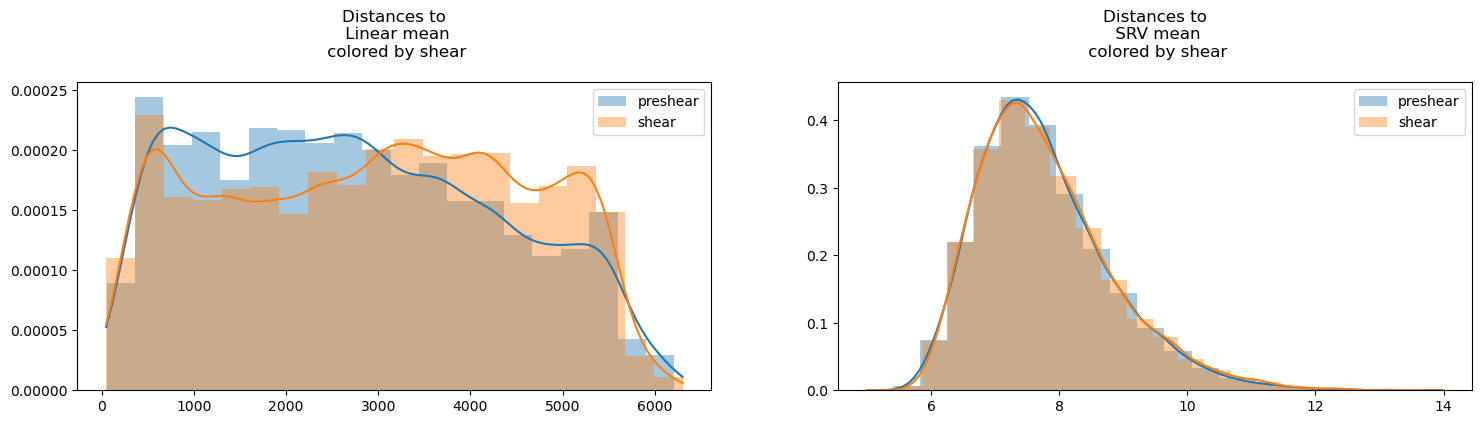

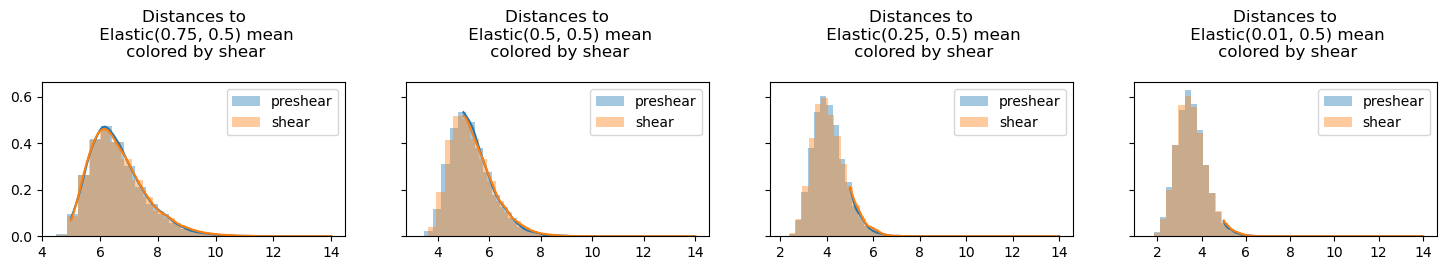

In [ ]:
hist_dists_to_means(labels_a, labels_a_name, label_color_incr=0)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_by_{labels_a_name}.svg"))

['proximal' 'proximal' 'proximal' ... 'distal' 'distal' 'distal']
location


shear  location       Linear       SRV  Elastic(0.75, 0.5)   
0         shear  proximal  1342.648682  7.529212            6.453674  \
1         shear  proximal  4140.452637  6.371561            5.485465   
2         shear  proximal   658.096069  6.296912            5.276754   
3         shear  proximal  6062.332031  6.335895            5.274429   
4         shear  proximal  1568.043823  6.717047            5.673367   
...         ...       ...          ...       ...                 ...   
40029  preshear    distal   556.606262  7.039009            6.008134   
40030  preshear    distal  3837.423828  8.537434            7.398668   
40031  preshear    distal  3481.139160  7.931010            6.742973   
40032  preshear    distal  1377.930054  7.746829            6.543987   
40033  preshear    distal  6082.951660  5.977164            4.964023   

       Elastic(0.5, 0.5)  Elastic(0.25, 0.5)  Elastic(0.01, 0.5)  
0               5.264397            4.220645            3.772818  
1               4.530110            3.715329            3.374729  
2               4.238960            3.379824            3.022968  
3               4.125103            3.100430            2.642484  
4               4.502517            3.439905            2.963932  
...                  ...                 ...                 ...  
40029           4.893580            3.926767            3.514289  
40030           6.107540            4.958422            4.463685  
40031           5.485555            4.414653            3.963486  
40032           5.208507            4.005444            3.470217  
40033           3.882159            2.928235            2.505511  

[40034 rows x 8 columns]

shear  location       Linear       SRV  Elastic(0.75, 0.5)   
0         shear  proximal  1342.648682  7.529212            6.453674  \
1         shear  proximal  4140.452637  6.371561            5.485465   
2         shear  proximal   658.096069  6.296912            5.276754   
3         shear  proximal  6062.332031  6.335895            5.274429   
4         shear  proximal  1568.043823  6.717047            5.673367   
...         ...       ...          ...       ...                 ...   
40029  preshear    distal   556.606262  7.039009            6.008134   
40030  preshear    distal  3837.423828  8.537434            7.398668   
40031  preshear    distal  3481.139160  7.931010            6.742973   
40032  preshear    distal  1377.930054  7.746829            6.543987   
40033  preshear    distal  6082.951660  5.977164            4.964023   

       Elastic(0.5, 0.5)  Elastic(0.25, 0.5)  Elastic(0.01, 0.5)  
0               5.264397            4.220645            3.772818  
1               4.530110            3.715329            3.374729  
2               4.238960            3.379824            3.022968  
3               4.125103            3.100430            2.642484  
4               4.502517            3.439905            2.963932  
...                  ...                 ...                 ...  
40029           4.893580            3.926767            3.514289  
40030           6.107540            4.958422            4.463685  
40031           5.485555            4.414653            3.963486  
40032           5.208507            4.005444            3.470217  
40033           3.882159            2.928235            2.505511  

[40034 rows x 8 columns]

shear  location       Linear       SRV  Elastic(0.75, 0.5)   
0         shear  proximal  1342.648682  7.529212            6.453674  \
1         shear  proximal  4140.452637  6.371561            5.485465   
2         shear  proximal   658.096069  6.296912            5.276754   
3         shear  proximal  6062.332031  6.335895            5.274429   
4         shear  proximal  1568.043823  6.717047            5.673367   
...         ...       ...          ...       ...                 ...   
40029  preshear    distal   556.606262  7.039009            6.008134   
40030  preshear    distal  3837.423828  8.537434            7.398668   
40031  preshear    distal  3481.139160  7.931010            6.742973   
40032  preshear    distal  1377.930054  7.746829            6.543987   
40033  preshear    distal  6082.951660  5.977164            4.964023   

       Elastic(0.5, 0.5)  Elastic(0.25, 0.5)  Elastic(0.01, 0.5)  
0               5.264397            4.220645            3.772818  
1               4.530110            3.715329            3.374729  
2               4.238960            3.379824            3.022968  
3               4.125103            3.100430            2.642484  
4               4.502517            3.439905            2.963932  
...                  ...                 ...                 ...  
40029           4.893580            3.926767            3.514289  
40030           6.107540            4.958422            4.463685  
40031           5.485555            4.414653            3.963486  
40032           5.208507            4.005444            3.470217  
40033           3.882159            2.928235            2.505511  

[40034 rows x 8 columns]

shear  location       Linear       SRV  Elastic(0.75, 0.5)   
0         shear  proximal  1342.648682  7.529212            6.453674  \
1         shear  proximal  4140.452637  6.371561            5.485465   
2         shear  proximal   658.096069  6.296912            5.276754   
3         shear  proximal  6062.332031  6.335895            5.274429   
4         shear  proximal  1568.043823  6.717047            5.673367   
...         ...       ...          ...       ...                 ...   
40029  preshear    distal   556.606262  7.039009            6.008134   
40030  preshear    distal  3837.423828  8.537434            7.398668   
40031  preshear    distal  3481.139160  7.931010            6.742973   
40032  preshear    distal  1377.930054  7.746829            6.543987   
40033  preshear    distal  6082.951660  5.977164            4.964023   

       Elastic(0.5, 0.5)  Elastic(0.25, 0.5)  Elastic(0.01, 0.5)  
0               5.264397            4.220645            3.772818  
1               4.530110            3.715329            3.374729  
2               4.238960            3.379824            3.022968  
3               4.125103            3.100430            2.642484  
4               4.502517            3.439905            2.963932  
...                  ...                 ...                 ...  
40029           4.893580            3.926767            3.514289  
40030           6.107540            4.958422            4.463685  
40031           5.485555            4.414653            3.963486  
40032           5.208507            4.005444            3.470217  
40033           3.882159            2.928235            2.505511  

[40034 rows x 8 columns]

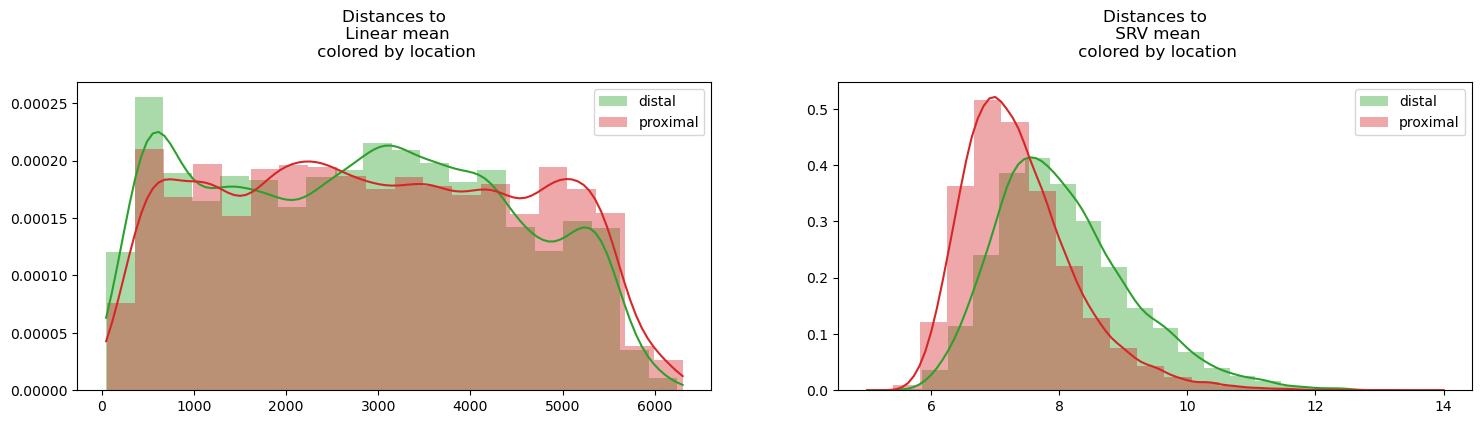

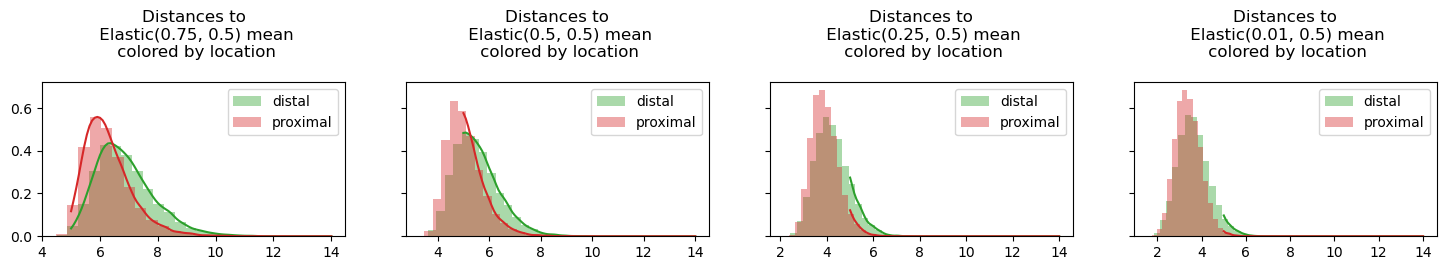

In [ ]:
hist_dists_to_means(labels_b, labels_b_name, label_color_incr=2)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_by_{labels_b_name}.svg"))

We observe that the histograms of distances vary between the:
- the histogram of distances to the linear mean
- the histogram of distances to the SRV mean.

For example, regarding the histograms colored by cell lines:
- the distributions of distances to the linear mean seem to show that dunn cells are closer to the mean, which is counter-intuitive since they look more irregular,
- the distributions of distances to the srv mean correctly reflec the fact that dunn cells are "further" from the mean.

For example, regarding the histograms colored by treatments:
- the distributions of distances to the linear mean show a peak of the control shapes in the center of the peaks for the cytd and jasp treatments
- while the distributions of distances computed with the SRV metric clearly shows a peak for the control that is closer to the mean shape, and the two peaks of the treatments that are further away.

We also observe that the histogram of jasp (in purple) shows two modes, that correspond to the two lines: this bimodality had not been observed on the histograms of distances to the Linear mean.

However, the histograms of distances to the Elastic means do not seem to bring interesting information.

Thus, for the remainder of this analysis, we focus on the comparison between the Linear mean and the SRV mean.

In [ ]:
print(i_lab_a)
print(i_lab_b)

1
1


In [ ]:
def full_hist_dists_to_means_split():
    for i, dist_name in enumerate(["Linear", "SRV"]):
        fig, axs = plt.subplots(len(np.unique(labels_a)), len(np.unique(labels_b)), figsize=(18, 8))
        for i_lab_a, label_a in enumerate(np.unique(labels_a)):
            for i_lab_b, label_b in enumerate(np.unique(labels_b)):
                ds = dists_summary[dist_name][
                    dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
                axs[i_lab_a, i_lab_b].hist(
                    ds, bins=20, alpha=0.4, density=True, label=label_a+"-"+label_b, color=f"C{i_lab_a+2*i_lab_b}"
                )
                kde = stats.gaussian_kde(ds)

                axs[i_lab_a, i_lab_b].plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab_a+2*i_lab_b}")
                axs[i_lab_a, i_lab_b].legend()
                axs[i_lab_a, i_lab_b].set_title(f"Distances to {dist_name} mean ")
        plt.tight_layout()

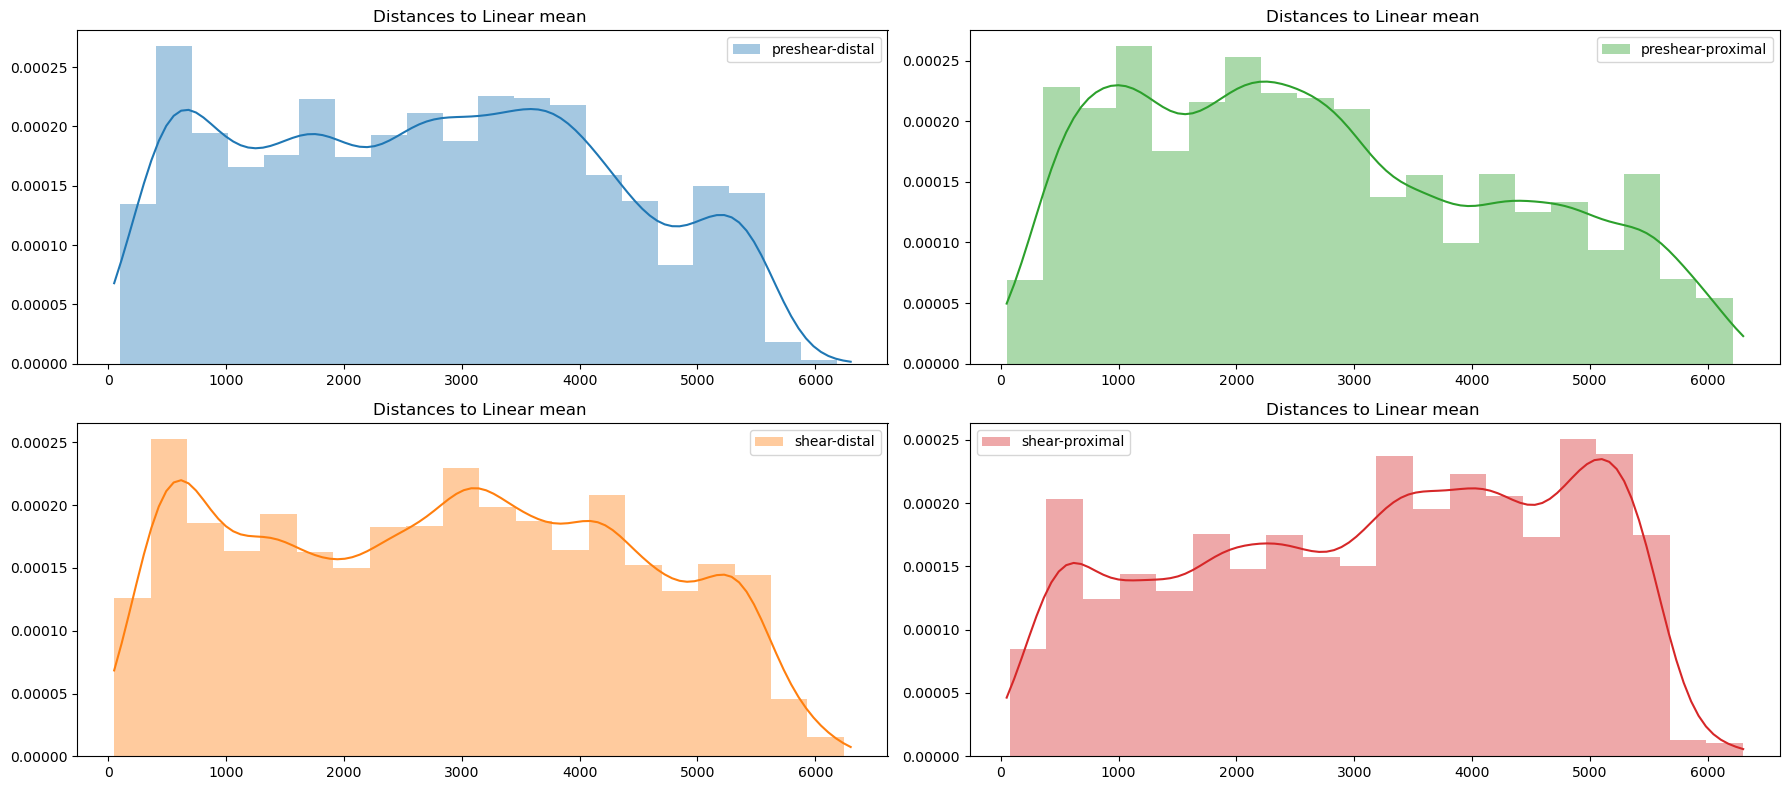

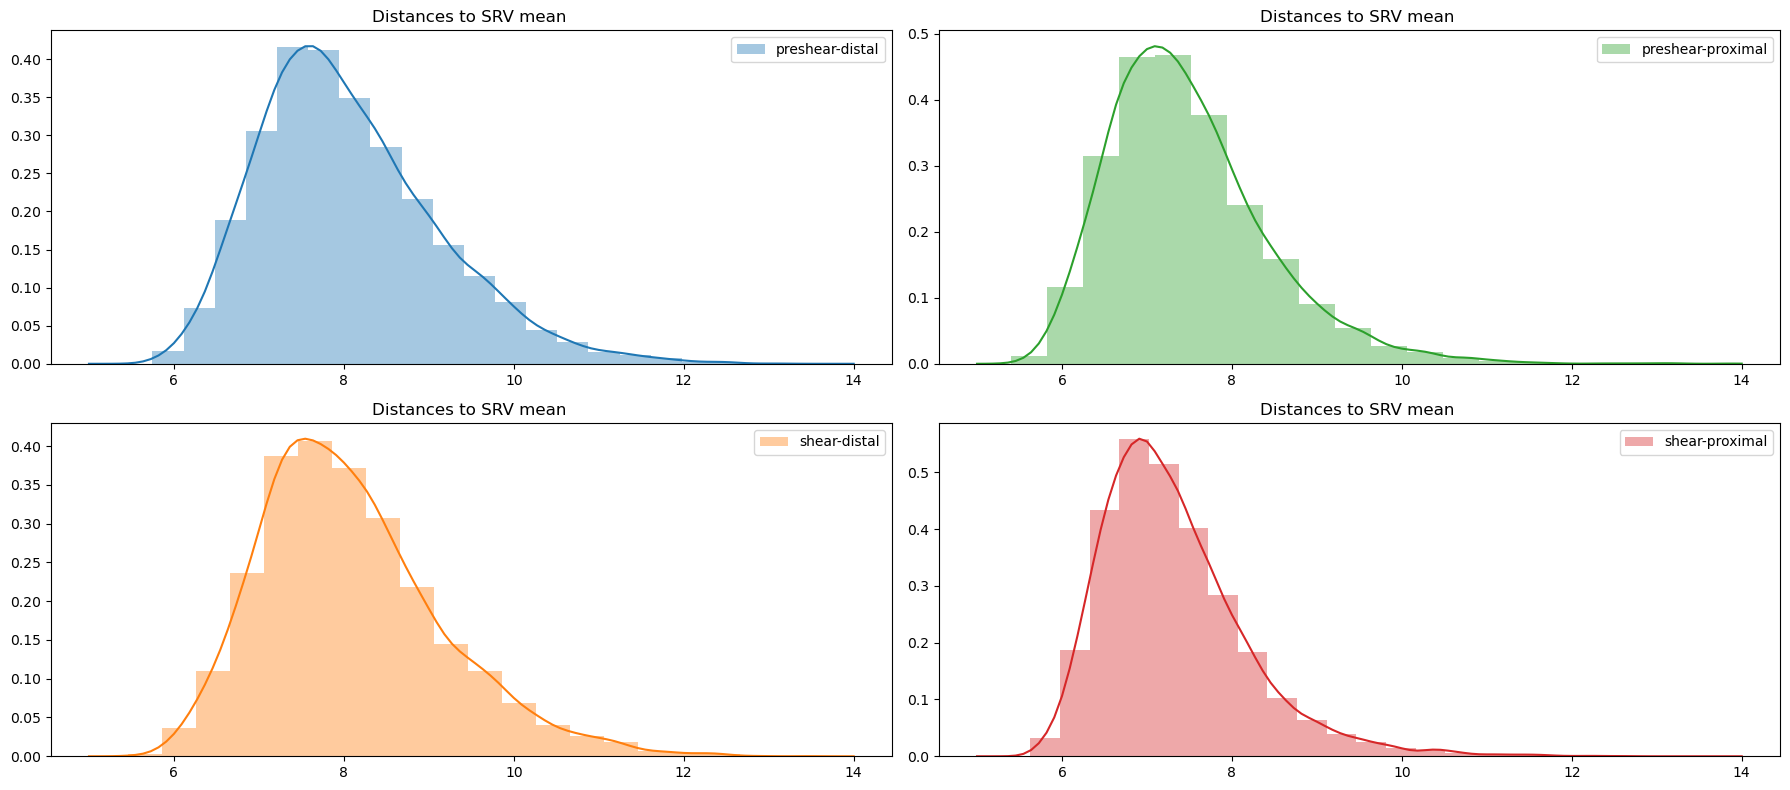

In [ ]:
full_hist_dists_to_means_split()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_all_split.svg"))

In [ ]:
def full_hist_dists_to_means_gather():
    for i, dist_name in enumerate(["Linear", "SRV"]):
        fig, axs = plt.subplots(1, 1, figsize=(12, 6))
        for i_lab_a, label_a in enumerate(np.unique(labels_a)):
            for i_lab_b, label_b in enumerate(np.unique(labels_b)):
                ds = dists_summary[dist_name][
                    dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
                axs.hist(
                    ds, bins=20, alpha=0.4, density=True, label=label_a+"-"+label_b, color=f"C{i_lab_a+2*i_lab_b}"
                )
                kde = stats.gaussian_kde(ds)

                axs.plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab_a+2*i_lab_b}")
                axs.legend()
                axs.set_title(f"Distances to {dist_name} mean ")
        plt.tight_layout()

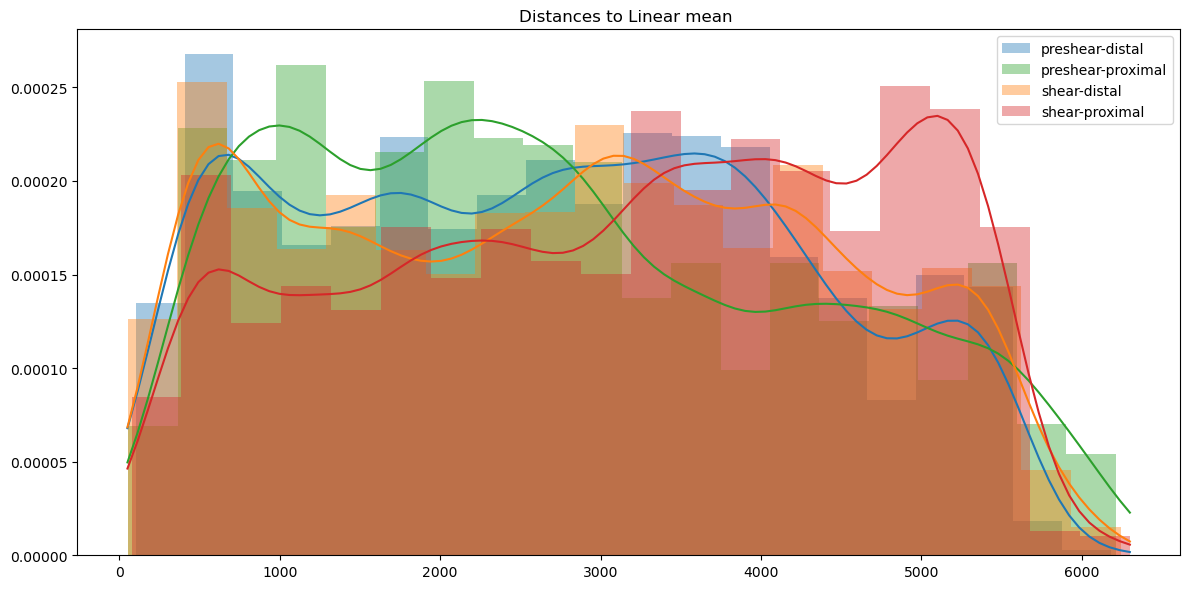

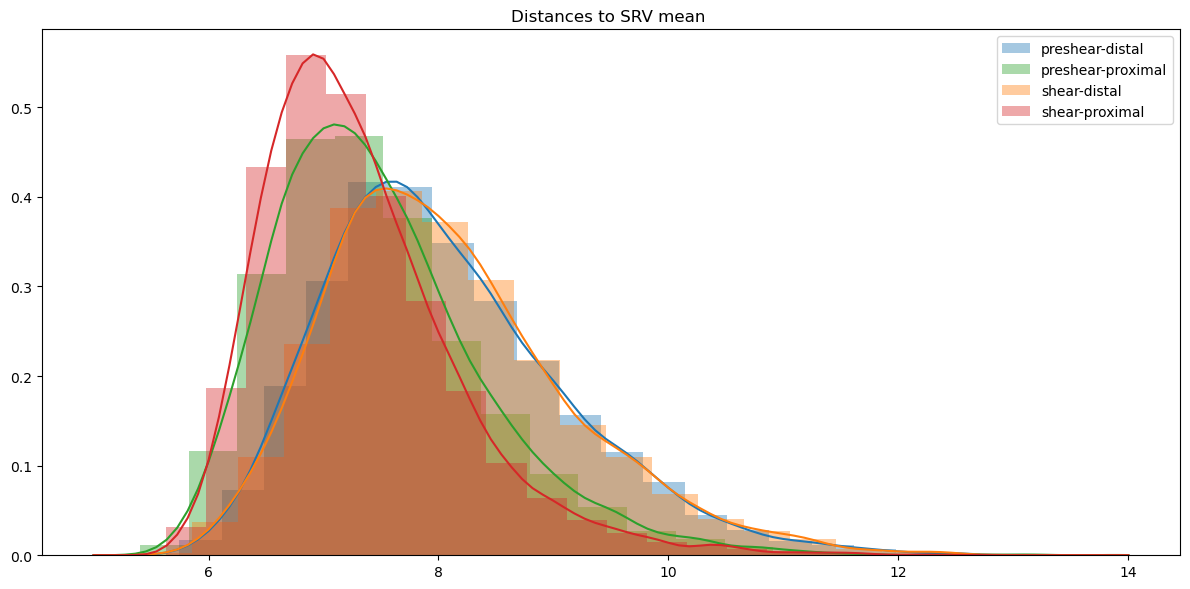

In [ ]:
full_hist_dists_to_means_gather()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_all_gather.svg"))

# Quantiles of distribution of distances to the mean(s)

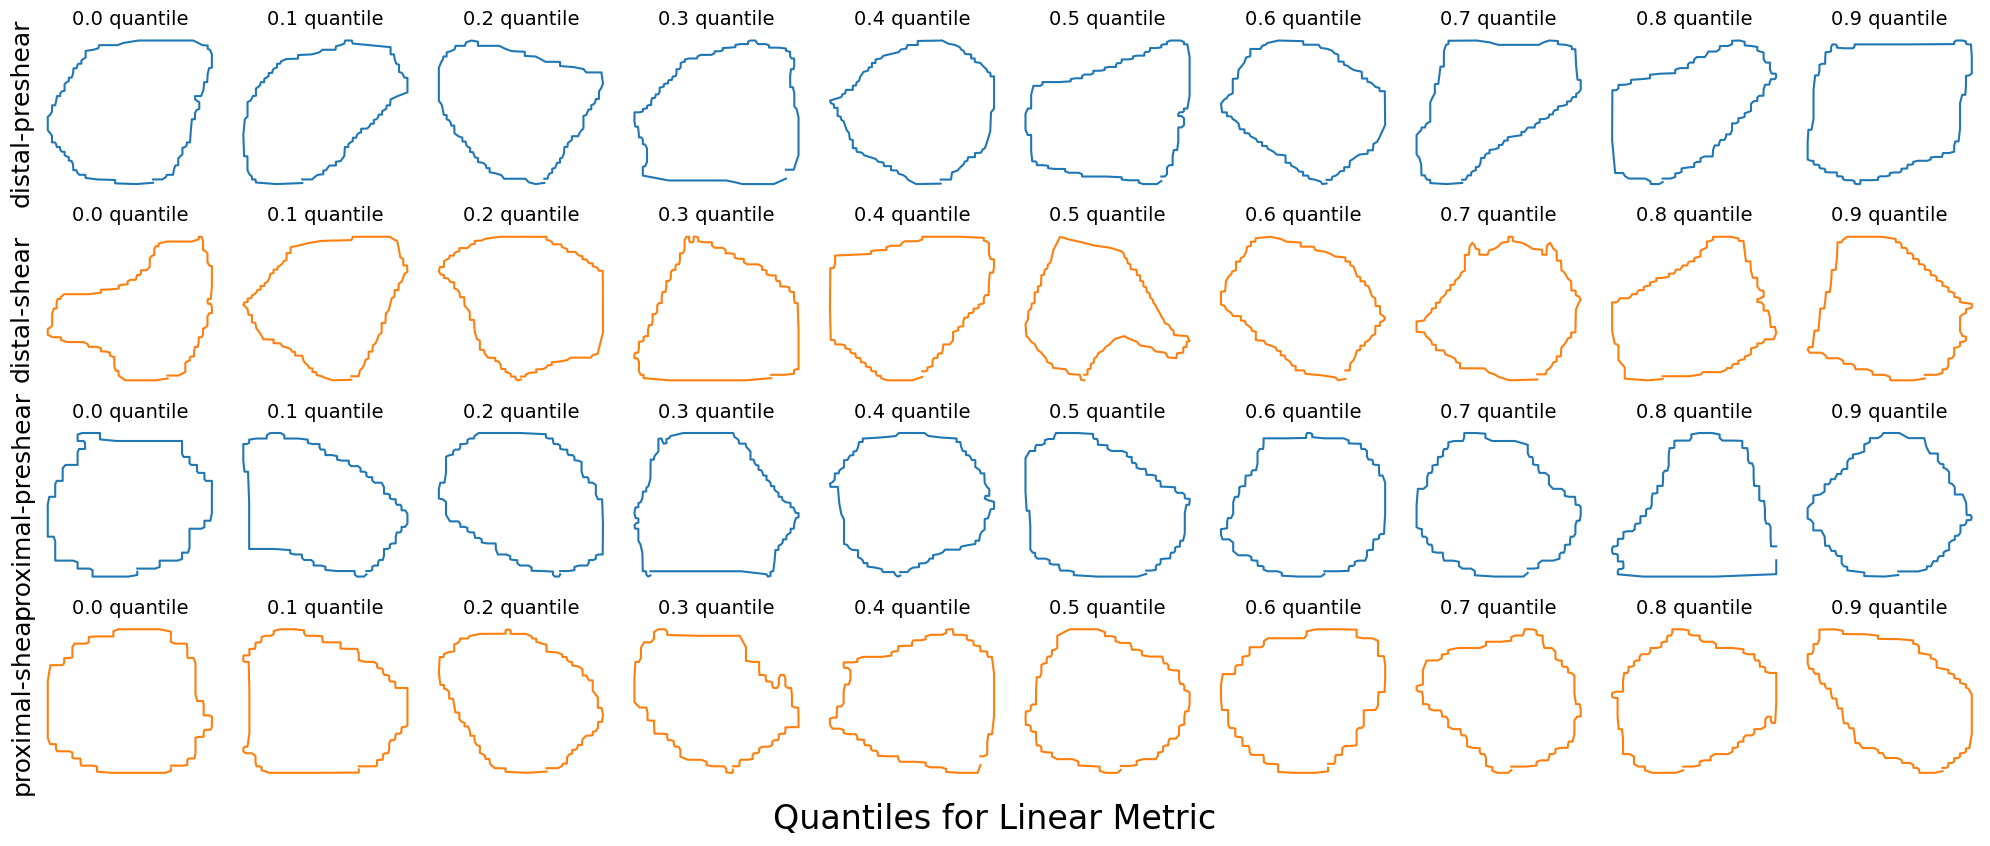

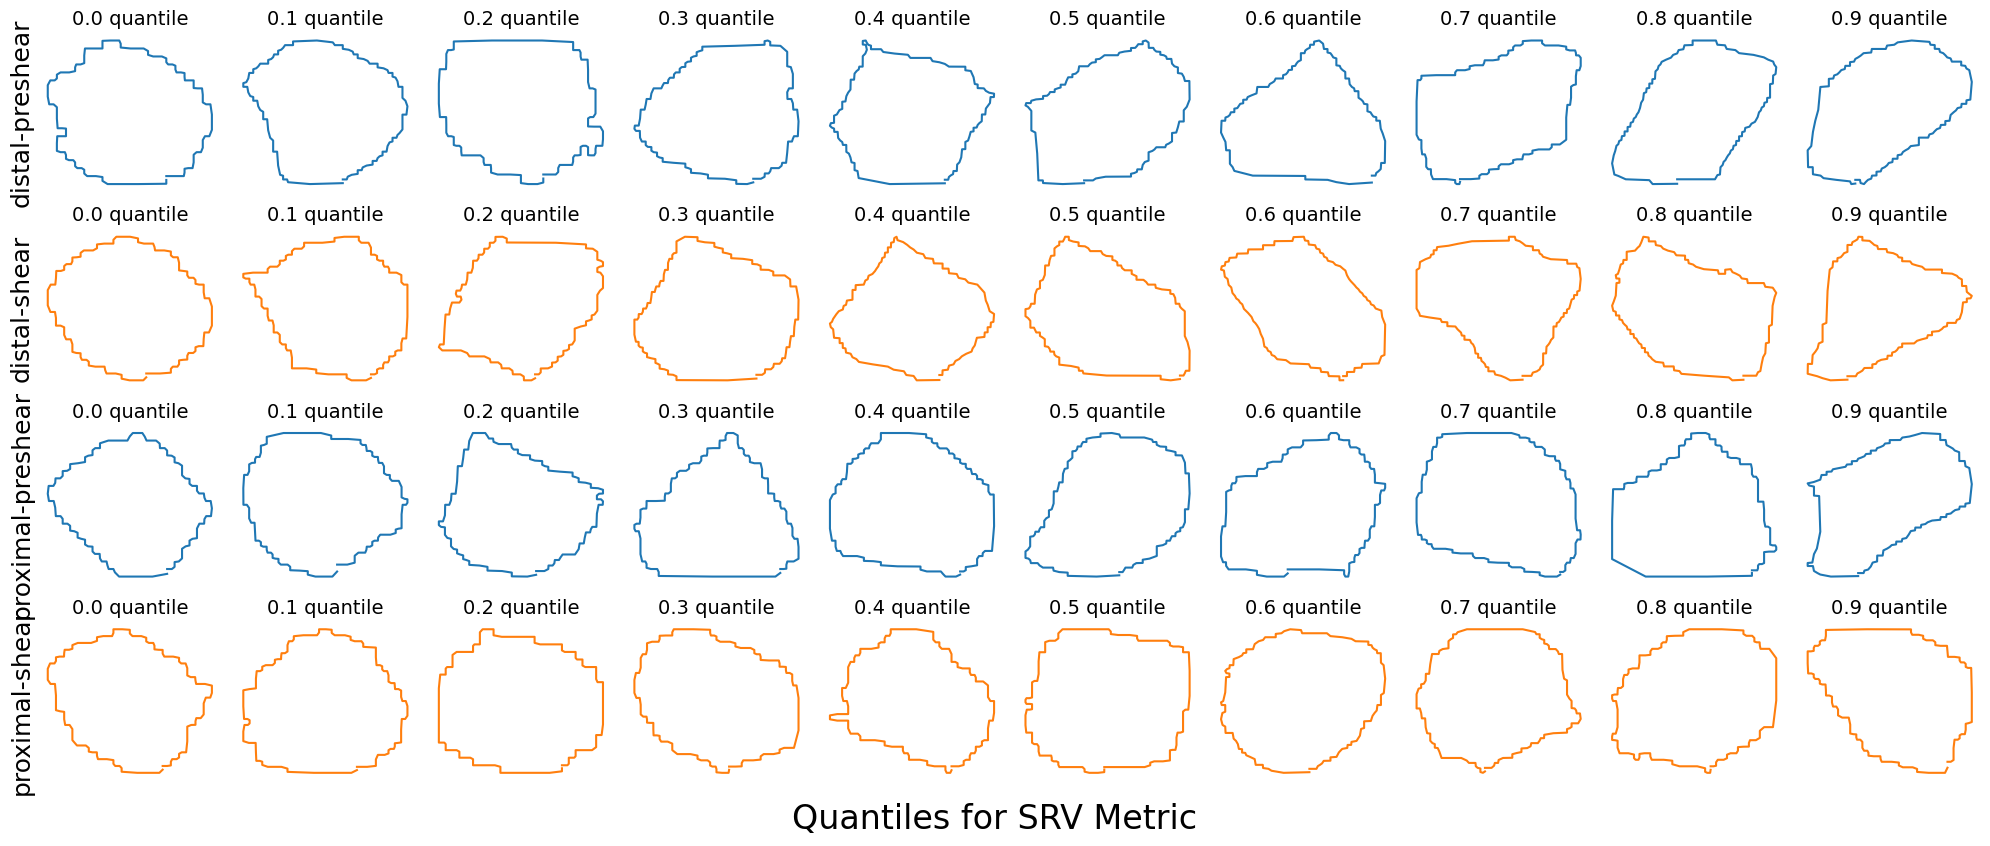

In [ ]:
for dist_name in ["Linear", "SRV"]:
    n_quantiles = 10
    fig, axes = plt.subplots(
        nrows=len(labels_b_dict) * len(labels_a_dict),
        ncols=n_quantiles,
        figsize=(20, 2 * len(labels_a_dict) * len(labels_b_dict)),
    )

    for i_lab_b, label_b in enumerate(np.unique(labels_b)):
        for j_lab_a, label_a in enumerate(np.unique(labels_a)):
            dists_list = dists_summary[dist_name][
                        dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
            # The following line ennsures that all values of distances are different, 
            # which is required in order to use the function "sorted" later
            dists_list = [d + 0.000001 * gs.random.rand(1)[0] for d in dists_list]
            cells_list = [cell for cell, lab_a, lab_b in zip(cell_shapes, labels_a, labels_b) if lab_a == label_a and lab_b == label_b]
            assert len(dists_list) == len(dists_list)
            n_cells = len(dists_list)

            zipped_lists = zip(dists_list, cells_list)
            sorted_pairs = sorted(zipped_lists)

            tuples = zip(*sorted_pairs)
            sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
            for i_quantile in range(n_quantiles):
                quantile = int(0.1 * n_cells * i_quantile)
                one_cell = sorted_cells_list[quantile]
                ax = axes[2 * i_lab_b + j_lab_a, i_quantile]
                ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j_lab_a}")
                ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
                # Turn off tick labels
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["bottom"].set_visible(False)
                ax.spines["left"].set_visible(False)
                if i_quantile == 0:
                    ax.set_ylabel(f"{label_b}-{label_a}", rotation=90, fontsize=18)
    plt.tight_layout()
    plt.suptitle(f"Quantiles for {dist_name} Metric", y=-0.01, fontsize=24)
    if SAVEFIG:
        plt.savefig(os.path.join(figs_dir, f"{now}_quantiles_{dist_name}.svg"))

# Clustering on distances with KMeans

We investigate whether KMeans performs differently when used with:
- the distances to the linear mean,
- the distances to the SRV mean.

In [ ]:
def reorder_confusion_matrix(cmat):
    def _make_cost_m(cm):
        s = np.max(cm)
        return -cm + s

    indexes = linear_assignment(_make_cost_m(cmat))
    js = sorted(indexes, key=lambda x: x[0])[1]
    cm2 = cmat[:, js]
    return cm2

In [ ]:
def confusion_kmean(labels, labels_name, labels_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for i, dist_name in enumerate(["Linear", "SRV"]):
        dists_arr = gs.expand_dims(gs.array(dists_summary[dist_name]), axis=1)
        kmeans = KMeans(n_clusters=len(labels_dict), random_state=0).fit(dists_arr)
        true_labels = [labels_dict[lab] for lab in labels]
        cm = confusion_matrix(true_labels, kmeans.labels_)
        cm = reorder_confusion_matrix(cm)

        axs[i].imshow(cm, interpolation="none", cmap="Blues")
        for (ii, jj), z in np.ndenumerate(cm):
            axs[i].text(jj, ii, z, ha="center", va="center")

        axs[i].axes.xaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].axes.yaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].set_xlabel("Kmeans labels")
        axs[i].set_ylabel("True labels")

        acc = 100 * (np.trace(cm) / np.sum(cm))
        axs[i].set_title(
            f"Clustering {labels_name} using \n  distances to {dist_name} mean \n Accuracy: {acc:.2f}%")

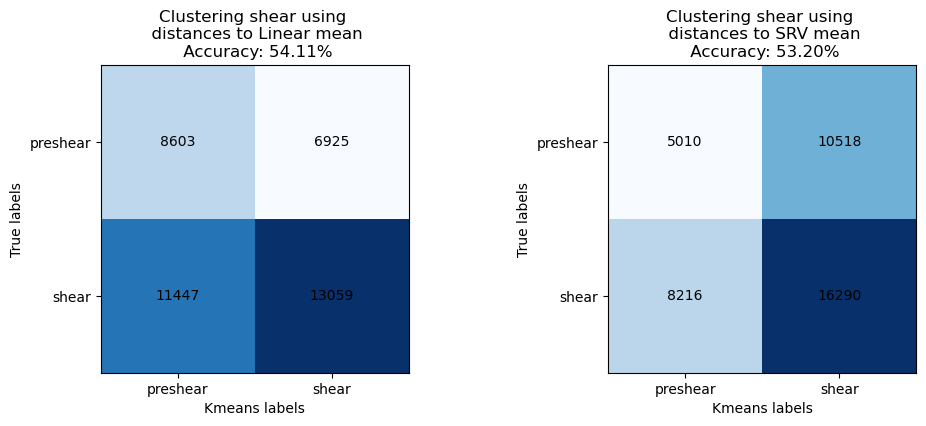

In [ ]:
confusion_kmean(labels_a, labels_a_name, labels_a_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_clustering_by_{labels_a_name}.svg"))

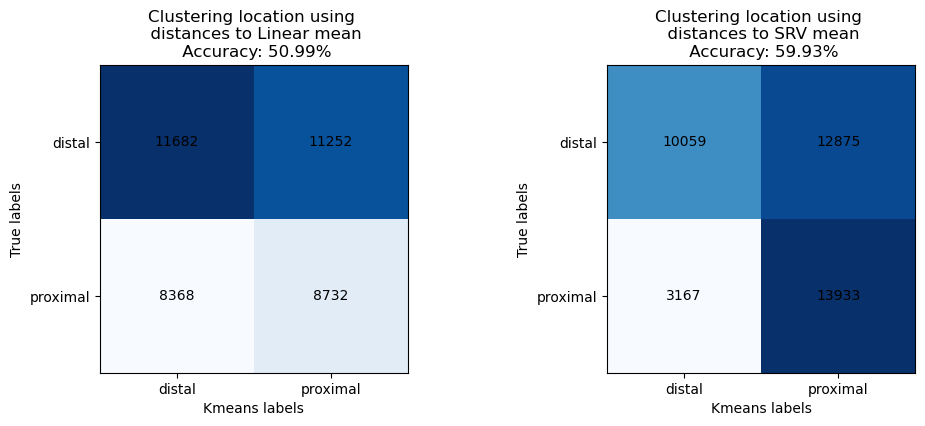

In [ ]:
confusion_kmean(labels_b, labels_b_name, labels_b_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_clustering_by_{labels_b_name}.svg"))

# Classification with Euclidean MDM and Riemannian MDM

In [ ]:
def confusion_mdm(labels, labels_name, labels_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    true_labels_ints = [labels_dict[lab] for lab in labels]

    for i, dist_name in enumerate(["Linear", "SRV"]):
        dists_arr = gs.expand_dims(gs.array(dists_summary[dist_name]), axis=1)        
        
        means_of_each_label = []
        for i_lab, lab in enumerate(np.unique(labels)):
            means_of_each_label.append(np.mean(  # mean of scalars in both cases
                dists_summary[dist_name][dists_summary[labels_name] == lab]))
        pred_labels_ints = []  
        for dist_cell in dists_arr:
            distdists = np.array([np.abs(dist_cell - m) for m in means_of_each_label])
            pred_labels_ints.append(np.argmin(distdists))
        
        cm = confusion_matrix(true_labels_ints, pred_labels_ints)
        cm = reorder_confusion_matrix(cm)

        axs[i].imshow(cm, interpolation="none", cmap="Blues")
        for (ii, jj), z in np.ndenumerate(cm):
            axs[i].text(jj, ii, z, ha="center", va="center")

        axs[i].axes.xaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].axes.yaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].set_xlabel("MDM labels")
        axs[i].set_ylabel("True labels")

        acc = 100 * (np.trace(cm) / np.sum(cm))
        axs[i].set_title(
            f"Classifying {labels_name} using \n  distances to {dist_name} mean \n Accuracy: {acc:.2f}%")

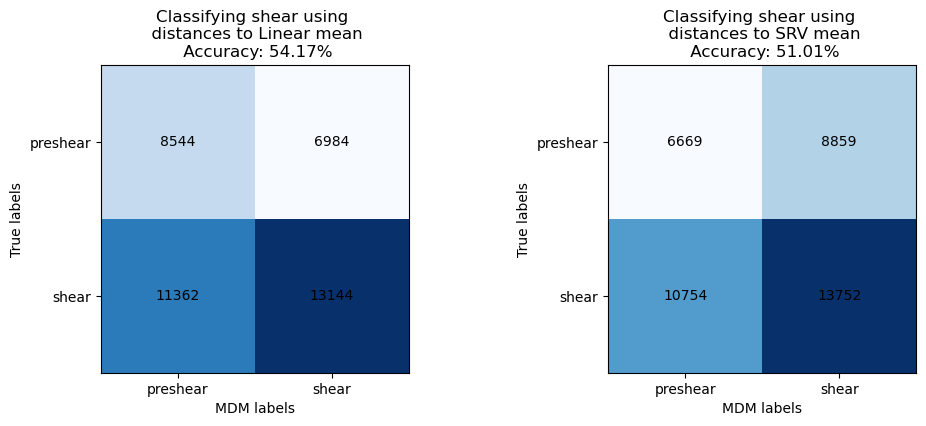

In [ ]:
confusion_mdm(labels_a, labels_a_name, labels_a_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_classification_by_{labels_a_name}.svg"))

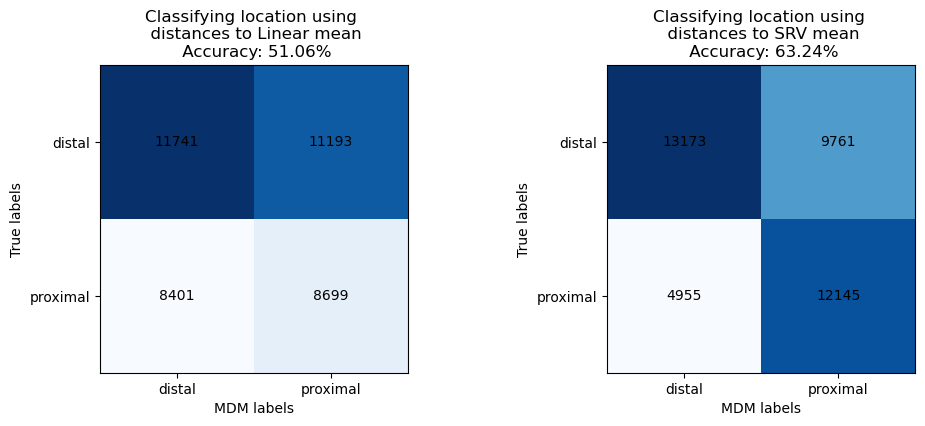

In [ ]:
confusion_mdm(labels_b, labels_b_name, labels_b_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_clustering_by_{labels_b_name}.svg"))

In both the unsupervised and supervised cases, we observe that some controls are clustered/classified as jasp. This makes sense from the histogram of distances, where we see that there is peak in the control distribution beneath the principal mode of the jasp distribution, or a peak in the jasp distribution beneath the principal mode of the control distribution.

# Dimension Reduction with PCA and tPCA

We investigate whether PCA and its Manifold equivalent (tangent PCA) performs differently when used with:
- the Euclidean (linear) metric,
- the SRV metric.

In [ ]:
cells_flat = gs.reshape(cells, (len(cells), -1))

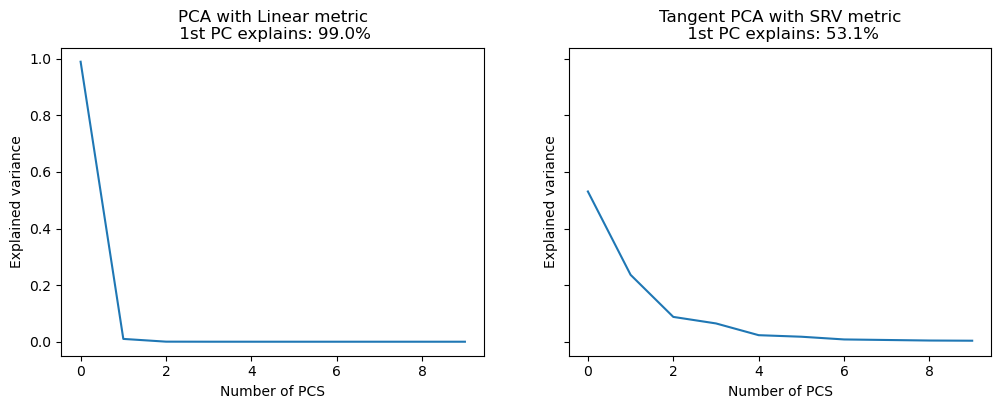

In [ ]:
n_components = 10

pcas = {}
pcas["Linear"] = PCA(n_components=n_components).fit(cells_flat)
pcas["SRV"] = TangentPCA(n_components=n_components, metric=SRV_METRIC).fit(cell_shapes)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i, metric_name in enumerate(["Linear", "SRV"]):
    axs[i].plot(pcas[metric_name].explained_variance_ratio_)
    axs[i].set_xlabel("Number of PCS")
    axs[i].set_ylabel("Explained variance")
    tangent = ""
    if metric_name == "SRV":
        tangent = "Tangent "
    first_pc_explains = 100*sum(pcas[metric_name].explained_variance_ratio_[:1])
    axs[i].set_title(f"{tangent}PCA with {metric_name} metric\n 1st PC explains: {first_pc_explains:.1f}%")
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_explained_variance.svg"))

We observe that the first principal components of the tangent PCA using the SRV metric captures a larger portion of the variance.

The first two components of the PCA with the Linear metric captures the following variance ratio:

In [ ]:
sum(pcas["Linear"].explained_variance_ratio_[:2])

0.9995114114135504

The first two components of the tangent PCA with the SRV metric captures the following variance ratio:

In [ ]:
sum(pcas["SRV"].explained_variance_ratio_[:2])

0.7673957067926777

We explore the projections of the cell data on the two principal components of each PCA.

The projections on the PCA of the SRV metric are more informative, as they have captured more variance.

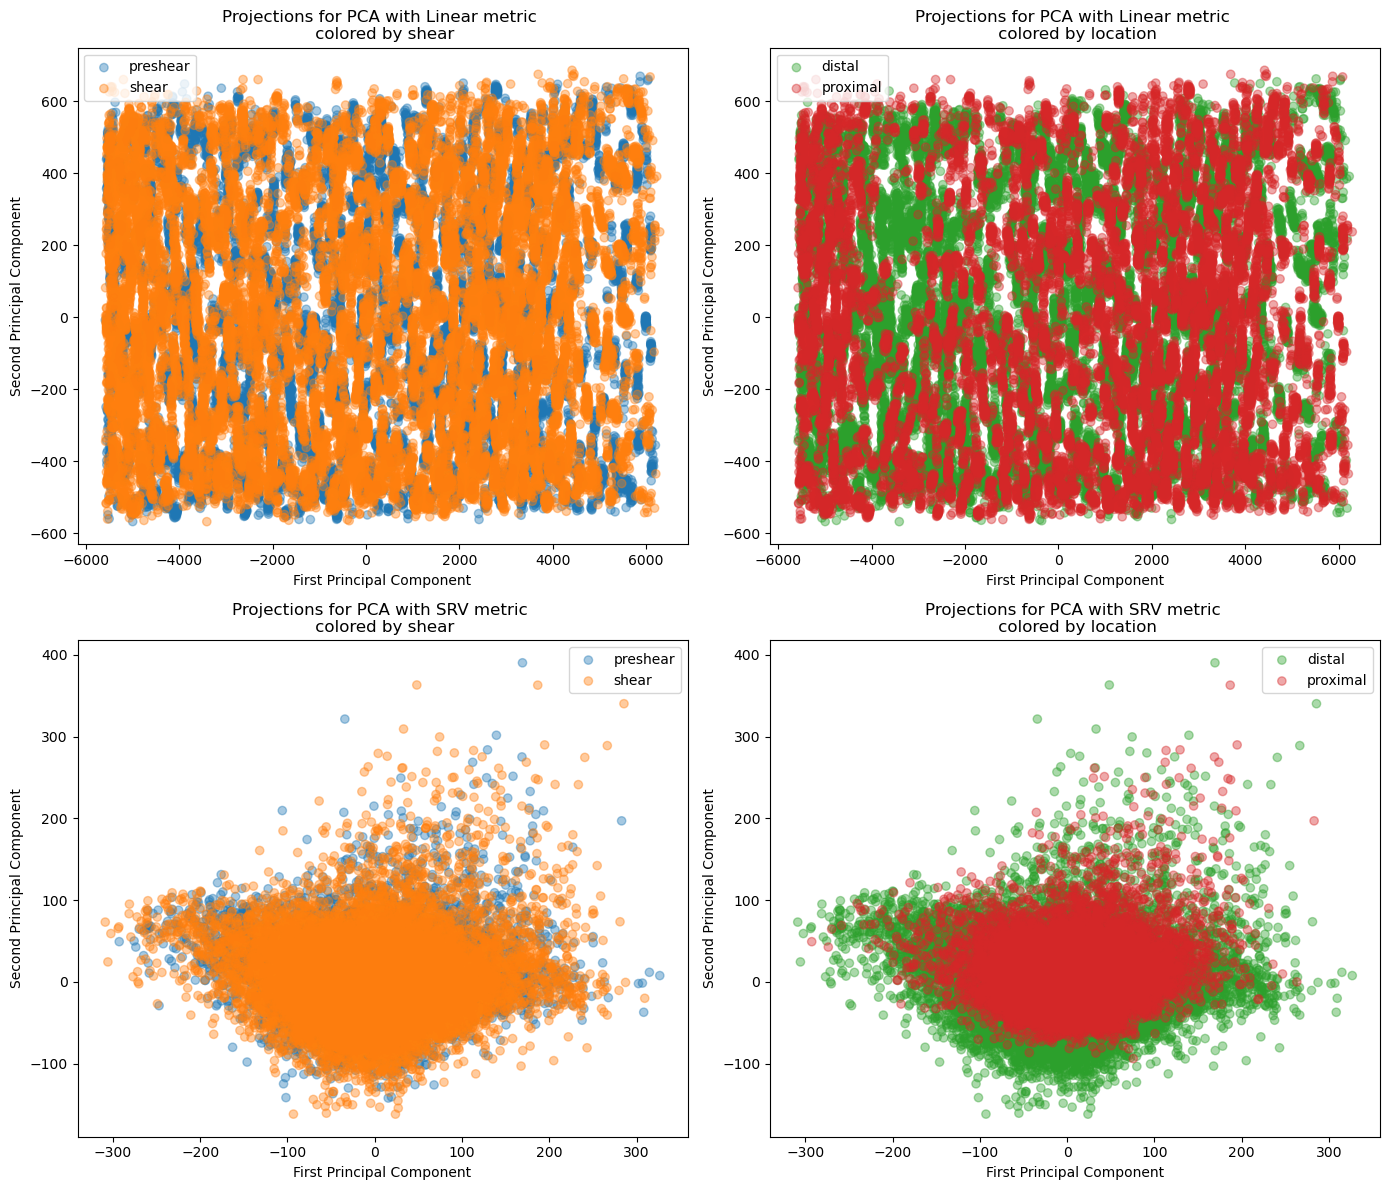

In [ ]:
cell_transformed = {}
cell_transformed["Linear"] = pcas["Linear"].fit_transform(cells_flat)
cell_transformed["SRV"] = pcas["SRV"].fit_transform(cell_shapes)

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_a_dict, labels_b_dict], [labels_a, labels_b], [labels_a_name, labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            cell_tr = cell_transformed[metric_name][dists_summary[labels_name] == label]
            axs[i, j].scatter(
                cell_tr[:, 0],
                cell_tr[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                label=label
            )
            axs[i, j].set_xlabel("First Principal Component")
            axs[i, j].set_ylabel("Second Principal Component")
            axs[i, j].set_title(
                f"Projections for PCA with {metric_name} metric \n colored by {labels_name}")
            axs[i, j].legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_projections_2d.svg"))

In [ ]:
times = np.arange(-0.5, 0.5, 0.1)

def plot_pc(geod, i_pc, metric_name):
    fig = plt.figure(figsize=(8, 1.3))
    for i, curve in enumerate(geod):
        fig.add_subplot(1, len(times), i + 1)
        plt.plot(curve[:, 0], curve[:, 1], c=f"C{i_pc+6}")
        plt.axis("equal")

        plt.axis("off")
        plt.tight_layout()
    fig.suptitle(f"Principal Component {i_pc} for {metric_name} metric")

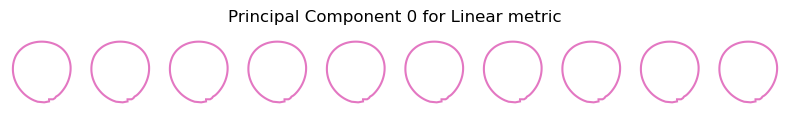

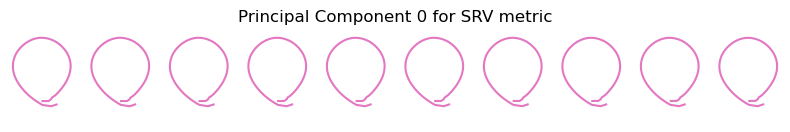

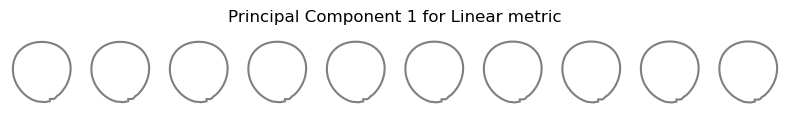

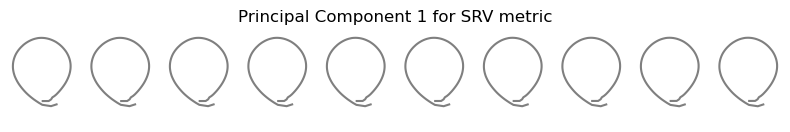

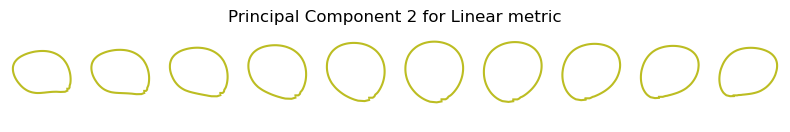

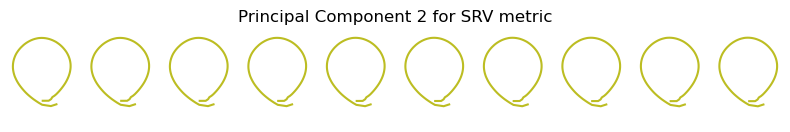

In [ ]:
n_pcs = 3

for i_pc in range(n_pcs):
    pc = means["Linear"] + np.einsum(
        "n,ij->nij", 300 * times, pcas["Linear"].components_[i_pc].reshape((n_sampling_points, 2))
    )
    plot_pc(pc, i_pc=i_pc, metric_name="Linear")

    gpc = SRV_METRIC.geodesic(
        initial_point=means["SRV"],
        initial_tangent_vec=pcas["SRV"].components_[i_pc].reshape((n_sampling_points, 2)),
    )(times)

    plot_pc(gpc, i_pc=i_pc, metric_name="SRV")
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_{n_pcs}_pcs.svg"))

# Dimension Reduction via MDS

We examine another dimension reduction technique: Multidimensional Scaling (MDS).

MDS relies on computing the (pairwise) distances between any two pairs of cells, which we do first using just in time compilation (jit) to speed up the computations.

In [ ]:
def linear_dist(cell1, cell2):
    return np.linalg.norm(cell1 - cell2) / n_sampling_points

def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points

In [ ]:
@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    n_cells = len(cells)
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i + 1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists

Using distance between cell shapes below:

In [ ]:
pairwise_dists = parallel_dist(cell_shapes, dist_fun=linear_dist)
pairwise_dists.shape

INFO: finding looplift candidates


(40034, 40034)

In [ ]:
# This takes 7min
pairwise_srv_dists = parallel_dist(cell_shapes, dist_fun=srv_dist)
pairwise_srv_dists.shape

(40034, 40034)

In [ ]:
mds = {}
pos = {}

mds["Linear"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["Linear"] = mds["Linear"].fit(pairwise_dists).embedding_

mds["SRV"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["SRV"] = mds["SRV"].fit(pairwise_srv_dists).embedding_

In [ ]:
print(len(pos["Linear"]))
print(len(pos["SRV"]))

40034
40034


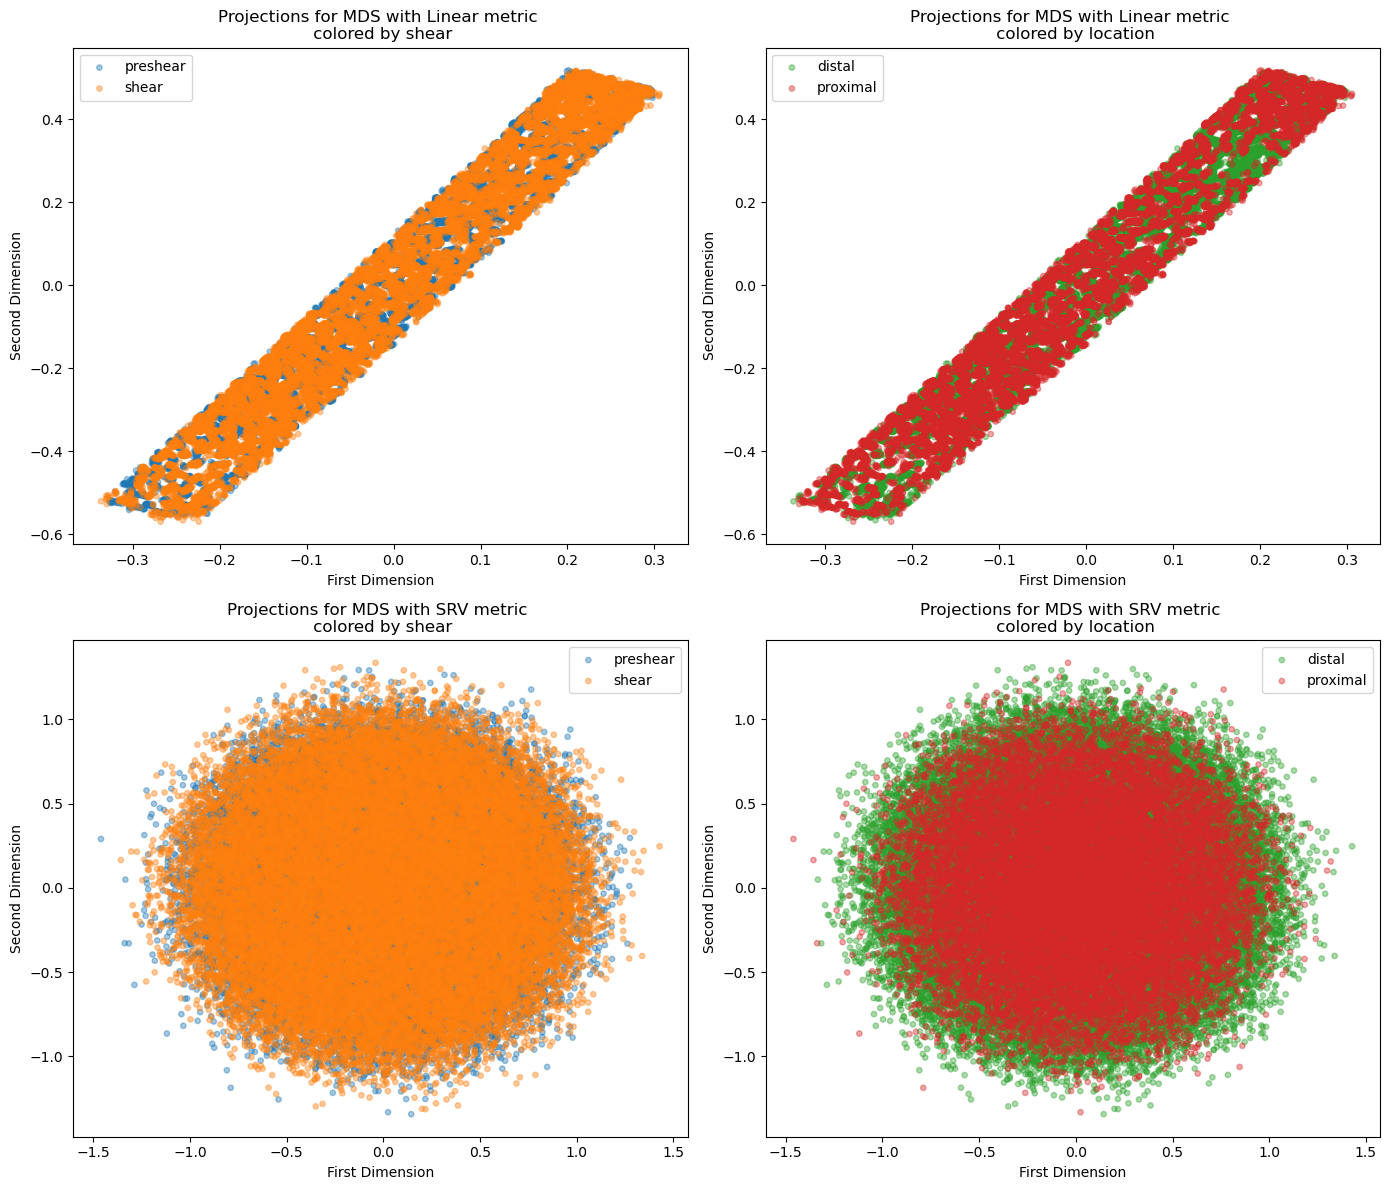

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_a_dict, labels_b_dict], [labels_a, labels_b], [labels_a_name, labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            position = pos[metric_name][dists_summary[labels_name] == label]
            if metric_name == "SRV":
                position = 1000 * position  # rescaling axis for display purposes
            axs[i, j].scatter(
                position[:, 0],
                position[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                s=15,
                label=label,
            )

            axs[i, j].set_xlabel("First Dimension")
            axs[i, j].set_ylabel("Second Dimension")
            axs[i, j].set_title(
                f"Projections for MDS with {metric_name} metric \n colored by {labels_name}")
            axs[i, j].legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_mds_projections_2d.svg"))

Interestingly, the MDS with the distances computed from the SRV metric shows a concentric organization of the treatment. The distance to the origin (0, 0) of the space seems related to the treatment.

We sample cell shapes around circles of different radii to explore whether the polar angle contains relevant information.

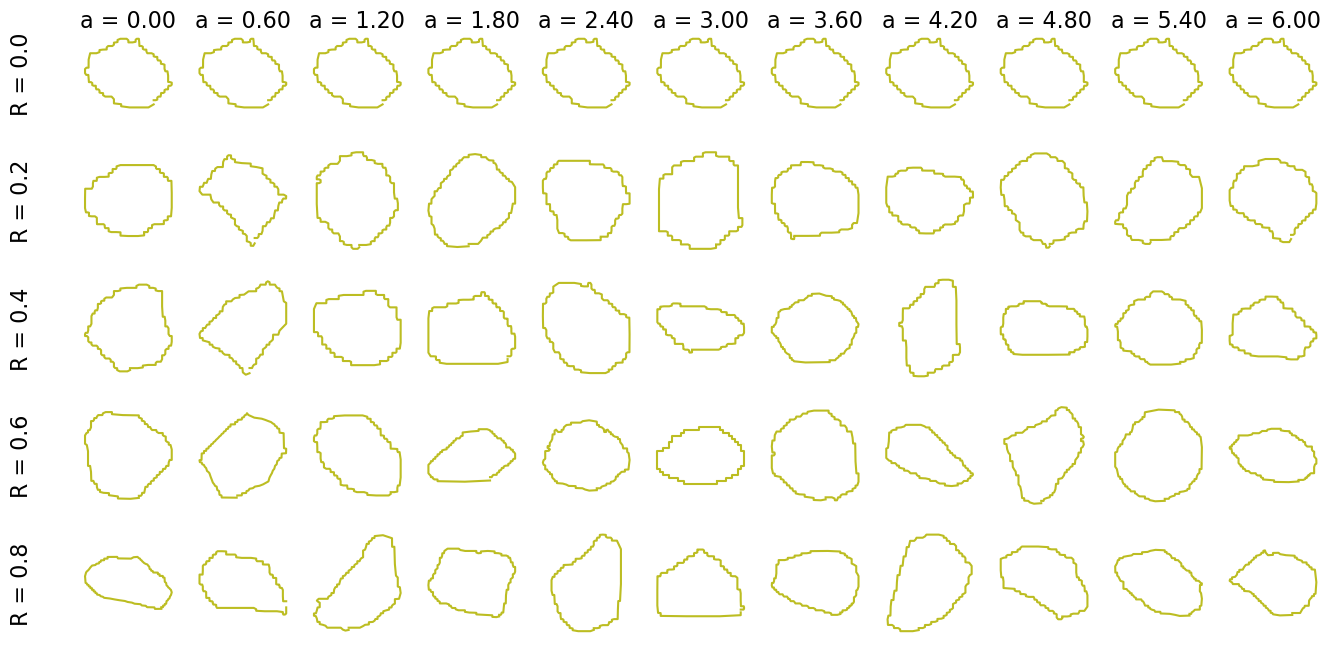

In [ ]:
fig = plt.figure(figsize=(16, 8))
thetas = np.arange(0, 2 * np.pi, 0.6)
radii = np.arange(0, 0.001, 0.0002)

left, width = -.5, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

count = 0
for i_radius, radius in enumerate(radii):
    for i_theta, theta in enumerate(thetas):
        ax = fig.add_subplot(len(radii), len(thetas), count + 1)

        pos_theta = np.array([radius * np.cos(theta), radius * np.sin(theta)])
        dists_theta = np.linalg.norm(pos_theta - pos["SRV"], axis=1)
        assert len(dists_theta) == len(cell_shapes)
        idx = np.argmin(dists_theta)

        ax.plot(cells[idx][:, 0], cells[idx][:, 1], c=f"C{i_pc+6}")
        ax.set_aspect("equal")
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if i_radius == 0:
            ax.set_title(f"a = {theta:.2f}", fontsize=16)
        if i_theta == 0:
            ax.text(-0.5, 0.5 * (bottom + top), f"R = {1000 * radius:.1f}", # rescaling for visualization
                horizontalalignment='right',
                verticalalignment='center',
                rotation='vertical',
                transform=ax.transAxes,
                fontsize=16)
        count += 1
    plt.ylabel(f"Radius: {radius}")
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_mds_from_radius_and_angle.svg"))

The following scatter plot shows that the radius in MDS space is the distance to the SRV mean shape.

In [ ]:
from scipy.stats import gaussian_kde

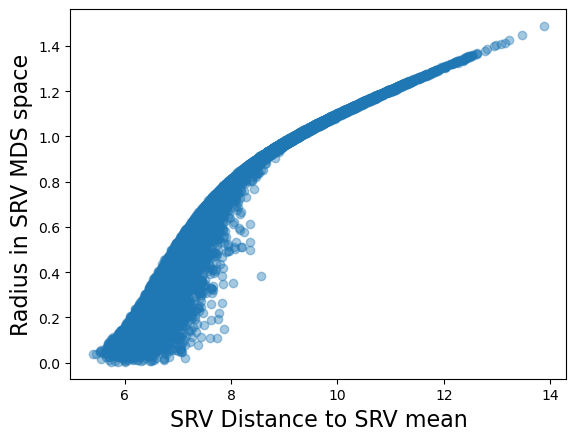

In [ ]:
plt.scatter(dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1), alpha=0.4)
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Radius in SRV MDS space", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_mds_radius_and_srv_dist.svg"))

(40034, 2)
20230613_13_35_47


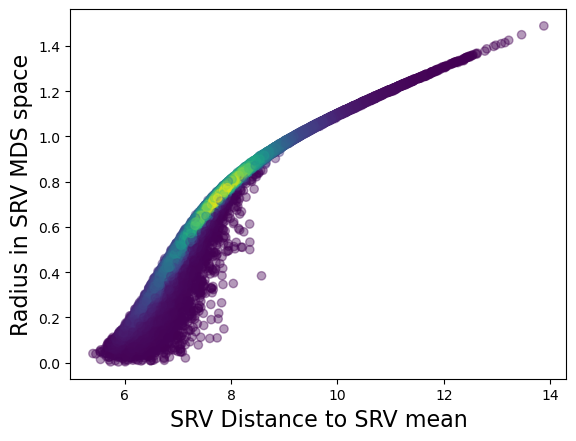

In [ ]:
points_to_plot = gs.stack([dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1)], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()
print(now)
plt.scatter(dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1), alpha=0.4, c=z_norm)
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Radius in SRV MDS space", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_mds_radius_and_srv_dist.svg"))

# SRV distance and area, perimeter

In [ ]:
areas = []
lengths = []
features = []
for cell in cells:
    area = basic.area(cell)
    length = basic.perimeter(cell)
    areas.append(area)
    lengths.append(length)
    features.append(area / length)

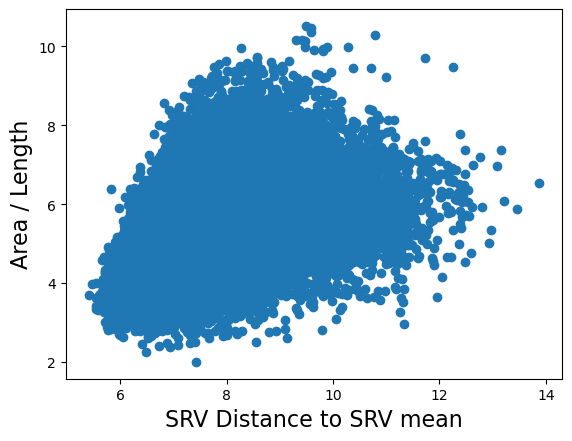

In [ ]:
plt.scatter(dists_summary["SRV"], features);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area / Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_arealength_and_srv_dist.svg"))

(40034, 2)


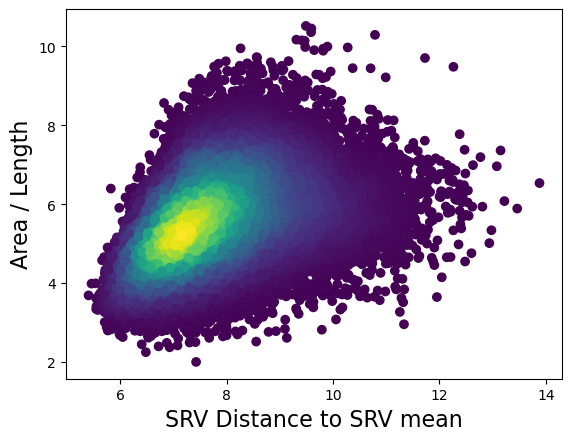

In [ ]:
points_to_plot = gs.stack([dists_summary["SRV"], features], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()

plt.scatter(dists_summary["SRV"], features, c=z_norm);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area / Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_arealength_and_srv_dist.svg"))

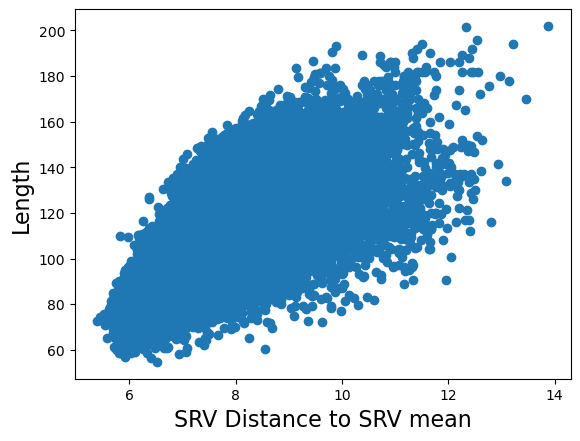

In [ ]:
plt.scatter(dists_summary["SRV"], lengths);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_length_and_srv_dist.svg"))

(40034, 2)


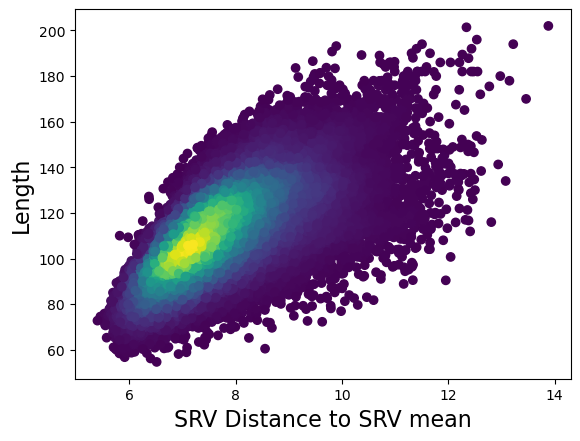

In [ ]:
points_to_plot = gs.stack([dists_summary["SRV"], lengths], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()
plt.scatter(dists_summary["SRV"], lengths, c=z_norm);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_length_and_srv_dist.svg"))

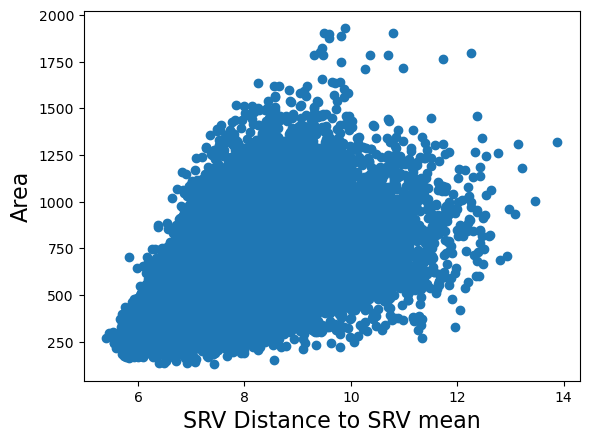

In [ ]:
plt.scatter(dists_summary["SRV"], areas);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_area_and_srv_dist.svg"))

We observe an almost perfect nonlinear correlation with the lenght of the curve. This is expected since the srv space is a space describing irregularities of the border of the cell, and irregularities are correlated with longer perimeter of a curve, -- for an equivalent area.

However, we note that the SRV space also provides additional degrees of symmetries, such that one can traverse this space, compute geodesics, computes means on a much complex object (the cell shape) than on just the length of the curve.

(40034, 2)


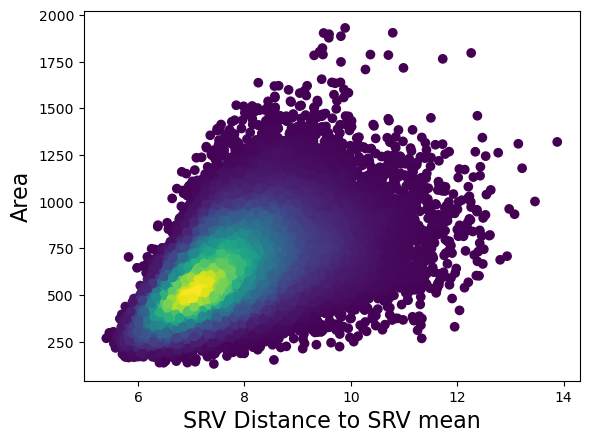

In [ ]:
points_to_plot = gs.stack([dists_summary["SRV"], areas], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()
plt.scatter(dists_summary["SRV"], areas,  c=z_norm);

plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_area_and_srv_dist.svg"))

In [ ]:
geodesic = SRV_METRIC.geodesic(initial_point=cells[0], end_point=cells[-1])
n_times = 30
times = gs.linspace(0.0, 1.0, n_times)
geod_points = geodesic(times)

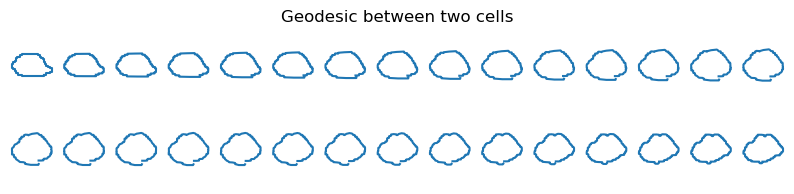

In [ ]:
fig = plt.figure(figsize=(10, 2))
plt.title("Geodesic between two cells")
plt.axis("off")

for i, curve in enumerate(geod_points):
    fig.add_subplot(2, n_times // 2, i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis("equal")
    plt.axis("off")
plt.savefig('geotwocells.png')

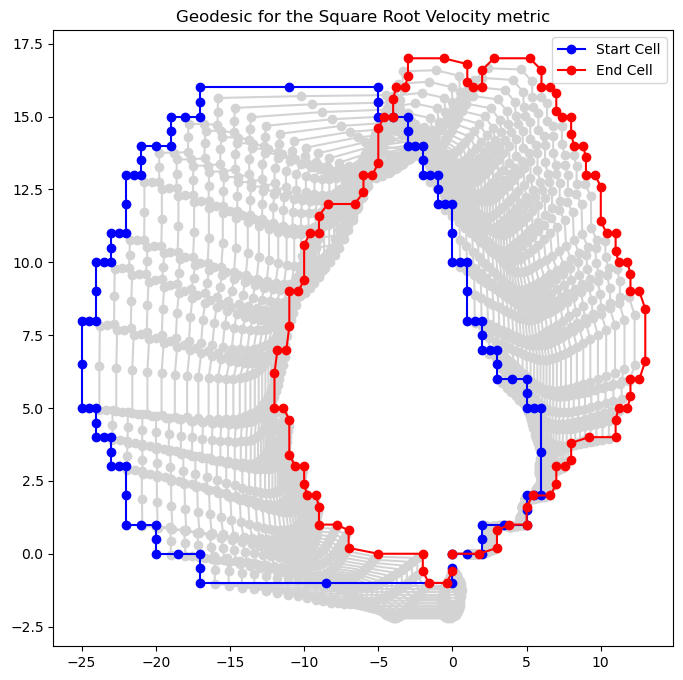

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(1, n_times - 1):
    plt.plot(geod_points[i, :, 0], geod_points[i, :, 1], "o-", color="lightgrey")
plt.plot(geod_points[0, :, 0], geod_points[0, :, 1], "o-b", label="Start Cell")
plt.plot(geod_points[-1, :, 0], geod_points[-1, :, 1], "o-r", label="End Cell")

plt.title("Geodesic for the Square Root Velocity metric")
plt.legend()
plt.show()

In [ ]:
from geomstats.learning.geodesic_regression import GeodesicRegression

gr = GeodesicRegression(
    space=preshape, metric=kendall_metric, 
    center_X=False, method="riemannian", initialization="warm_start")

# Warm-start
gr.intercept_ = y_train[0]  # theta0
gr.coef_ = kendall_metric.log(y_train[-1], y_train[0]) # theta1

NameError: name 'preshape' is not defined